# **Notebook zur Evaluation - Scan-Prozess**
***

In [1]:
from FC.FC_save_load_global_hook_dict import load_csv_to_dict
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
import numpy as np
from scipy.stats import norm
from sklearn.mixture import GaussianMixture
import os
import matplotlib.cm as cm

***
## **Wiederholungsgenauigkeit**

**Dicts laden**

In [2]:
dir_path = '/home/mo/Thesis/Evaluation/1_Scan-Prozess/6_Wiederholungsgenauigkeit/HakenmodellA/csv'

In [3]:
dicts_list = []

for testrun_folder in sorted(os.listdir(dir_path)):
    testrun_folder_path = os.path.join(dir_path, testrun_folder)

    if os.path.isdir(testrun_folder_path) and testrun_folder.isdigit():
        data = os.listdir(testrun_folder_path)
        csv_data = [f for f in data if f.endswith('.csv')]

        if len(csv_data) == 1:
            csv_path = os.path.join(testrun_folder_path, csv_data[0])
            dicts_list.append(load_csv_to_dict(csv_path))
        else:
            print(f"No CSV file in: {testrun_folder_path}")

print(f"{len(dicts_list)} Dictionaries found...")

50 Dictionaries found...


**Mittelwert der Koordinaten pro Haken berechnen**

In [4]:
def calculate_mean(dicts_list = None):
    """
    Berechnet für alle Koordnaten (Spitze und Senke) den Mittelwert X_mean, Y_mean, Z_mean für jeden Haken"
    """
    mean_xyz_tip_in_workframe = []
    mean_xyz_lowpoint_in_workframe = []

    for hook_idx in range(len(dicts_list[0])):
        # hole Haken x aus allen dicts und berechne Summe
        sum_xyz_tip = np.zeros(3)
        sum_xyz_lowpoint = np.zeros(3)
        
        dict_key = str(hook_idx + 1)
        for dict in (dicts_list):
            xyz_tip_in_workframe = dict[dict_key]['xyz_tip_in_workframe']
            xyz_lowpoint_in_workframe = dict[dict_key]['xyz_lowpoint_in_workframe']
            sum_xyz_tip += xyz_tip_in_workframe
            sum_xyz_lowpoint += xyz_lowpoint_in_workframe
        
        # Berechne Mittelwert für Haken x und hänge an Ergebnis-Liste dran
        tip_mean = sum_xyz_tip / len(dicts_list)
        lowpoint_mean = sum_xyz_lowpoint / len(dicts_list)
        mean_xyz_tip_in_workframe.append(tip_mean)
        mean_xyz_lowpoint_in_workframe.append(lowpoint_mean)

    return mean_xyz_tip_in_workframe, mean_xyz_lowpoint_in_workframe

**Werte als Scatter plotten**

In [5]:
def plot_values(dicts_list=None, tip_mean_list=None, lowpoint_mean_list=None):
    """
    Plottet die x, y, z-Werte für jeden Haken-Tip und -Lowpoint in einem 2x3 Plot.
    Links: Tip-Koordinaten (x, y, z)
    Rechts: Lowpoint-Koordinaten (x, y, z)
    """
    num_hooks = len(dicts_list[0])
    num_samples = len(dicts_list)

    # Datenstruktur initialisieren
    tips = np.zeros((num_hooks, num_samples, 3))       # shape: (hooks, samples, xyz)
    lowpoints = np.zeros((num_hooks, num_samples, 3))  # shape: (hooks, samples, xyz)

    for hook_idx in range(num_hooks):
        dict_key = str(hook_idx + 1)
        for sample_idx, d in enumerate(dicts_list):
            tips[hook_idx, sample_idx] = d[dict_key]['xyz_tip_in_workframe']
            lowpoints[hook_idx, sample_idx] = d[dict_key]['xyz_lowpoint_in_workframe']

    fig, axs = plt.subplots(3, 2, figsize=(20, 10), sharex=True)
    fig.suptitle('Wiederholungsgenauigkeit bei gleichem Hakenmodell bzw. Setup', fontsize=16)
    coord_labels = ['x', 'y', 'z']

    for i in range(3):  # Für x, y, z
        # Tip-Daten plotten (linke Spalte)
        # axs[i, 0].plot(range(1, num_hooks + 1), tips[:, :, i].mean(axis=1), label='Mean', marker='o')
        axs[i, 0].scatter(np.repeat(np.arange(1, num_hooks + 1), num_samples), 
                         tips[:, :, i].flatten(), alpha=0.6, label='Koordinate')
        if tip_mean_list:
            axs[i, 0].plot(range(1, num_hooks + 1), [tip_mean_list[hook_idx][i] for hook_idx in range(num_hooks)], 
                           label='Mittelwert', linestyle='--', color='red')
        axs[i, 0].set_ylabel(f'Spitze {coord_labels[i]}')
        axs[i, 0].legend()
        axs[i, 0].grid()

        # Lowpoint-Daten plotten (rechte Spalte)
        # axs[i, 1].plot(range(1, num_hooks + 1), lowpoints[:, :, i].mean(axis=1), label='Mean', marker='o')
        axs[i, 1].scatter(np.repeat(np.arange(1, num_hooks + 1), num_samples), 
                         lowpoints[:, :, i].flatten(), alpha=0.6, label='Koordinate')
        if lowpoint_mean_list:
            axs[i, 1].plot(range(1, num_hooks + 1), [lowpoint_mean_list[hook_idx][i] for hook_idx in range(num_hooks)], 
                           label='Mittelwert', linestyle='--', color='red')
        axs[i, 1].set_ylabel(f'Senke {coord_labels[i]}')
        axs[i, 1].legend()
        axs[i, 1].grid()

    for ax in axs[2]:
        ax.set_xlabel('Haken-Instanz')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

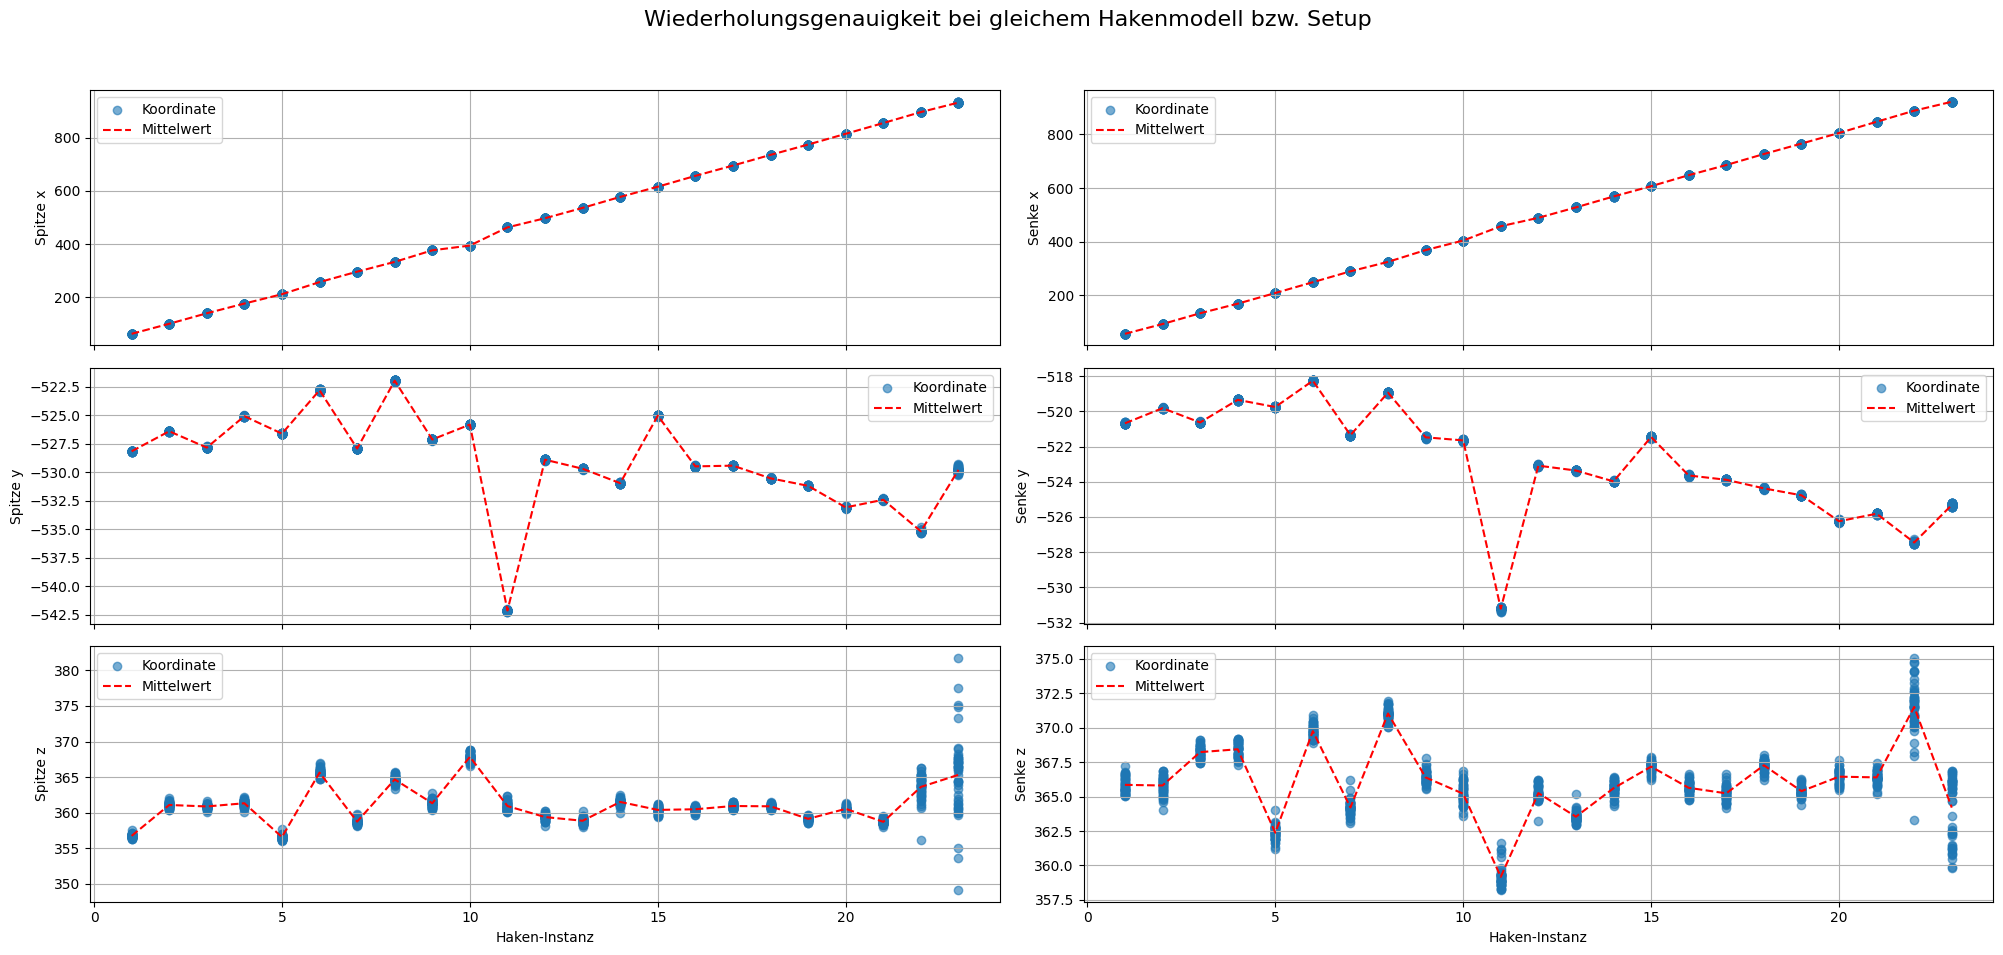

In [6]:
mean_xyz_tip_in_workframe, mean_xyz_lowpoint_in_workframe = calculate_mean(dicts_list)
plot_values(dicts_list = dicts_list, tip_mean_list = mean_xyz_tip_in_workframe, lowpoint_mean_list = mean_xyz_lowpoint_in_workframe)

### **Wahrscheinlichkeits-Verteilung**

**Berechnung der Treffer-Wahrscheinlichkeit - Spitze wird als unendlich kleiner Punkt angenommen**

In [7]:
def probability_within_slot_gmm(dicts_list, hook_num=1, slot_length=12, slot_width=5, slot_depth=10, n_components=2):
    coords = {'x': [], 'y': [], 'z': []}
    for d in dicts_list:
        pt = d[str(hook_num)]['xyz_tip_in_workframe']
        coords['x'].append(pt[0])
        coords['y'].append(pt[1])
        coords['z'].append(pt[2])

    slot_half = {
        'x': slot_width / 2,
        'y': slot_depth / 2,
        'z': slot_length / 2
    }

    total_prob = 1.0
    for axis in ['x', 'y', 'z']:
        data = np.array(coords[axis]).reshape(-1, 1)
        gmm = GaussianMixture(n_components=n_components, random_state=0)
        gmm.fit(data)

        weights = gmm.weights_
        means = gmm.means_.flatten()
        stds = np.sqrt(gmm.covariances_.flatten())
        center = np.mean(data)
        lower = center - slot_half[axis]
        upper = center + slot_half[axis]

        # Komponentensumme der Wahrscheinlichkeit
        prob_axis = 0
        for w, mu, sigma in zip(weights, means, stds):
            cdf_upper = norm.cdf((upper - mu) / sigma)
            cdf_lower = norm.cdf((lower - mu) / sigma)
            prob_axis += w * (cdf_upper - cdf_lower)

        print(f"{axis}-Achse: μ-Komponenten = {np.round(means, 2)}, σ-Komponenten = {np.round(stds, 2)}, Gewichte = {np.round(weights, 2)}")
        print(f"Zielbereich: [{lower:.2f}, {upper:.2f}] → Wahrscheinlichkeit = {prob_axis*100:.2f} %\n")
        total_prob *= prob_axis

    print(f"Gesamte Wahrscheinlichkeit für das Treffen der Hakenspitze (GMM): {total_prob*100:.2f} %\n")
    return total_prob

In [8]:
prob = probability_within_slot_gmm(dicts_list, hook_num=10, slot_length=12, slot_width=8, slot_depth=10, n_components=1)

x-Achse: μ-Komponenten = [394.48], σ-Komponenten = [0.05], Gewichte = [1.]
Zielbereich: [390.48, 398.48] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-525.82], σ-Komponenten = [0.03], Gewichte = [1.]
Zielbereich: [-530.82, -520.82] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [367.84], σ-Komponenten = [0.54], Gewichte = [1.]
Zielbereich: [361.84, 373.84] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit für das Treffen der Hakenspitze (GMM): 100.00 %



**Berechnung der Treffer-Wahrscheinlichkeit unter Berücksichtigung der Spitzendicke und der Lochgröße**

In [9]:
def probability_within_slot_gmm(dicts_list, hook_num=1,
                                 slot_length=12, slot_width=5, slot_depth=10,
                                 tip_width=7, tip_to_lp_dist=9, tip_length=10,
                                 n_components=2):
    coords = {'x': [], 'y': [], 'z': []}
    for d in dicts_list:
        pt = d[str(hook_num)]['xyz_tip_in_workframe']
        coords['x'].append(pt[0])
        coords['y'].append(pt[1])
        coords['z'].append(pt[2])

    # Sicherheitsabstand: Halbe Slotgröße MINUS halbe Spitzenabmessung
    slot_half = {
        'x': (slot_width / 2) - (tip_width / 2),
        'y': (slot_depth / 2) - (tip_to_lp_dist / 2),
        'z': (slot_length / 2) - (tip_length / 2)
    }

    for axis in ['x', 'y', 'z']:
        if slot_half[axis] <= 0:
            raise ValueError(f"Spitze ist größer als das Slot in {axis}-Richtung!")

    total_prob = 1.0
    for axis in ['x', 'y', 'z']:
        data = np.array(coords[axis]).reshape(-1, 1)
        gmm = GaussianMixture(n_components=n_components, random_state=0)
        gmm.fit(data)

        weights = gmm.weights_
        means = gmm.means_.flatten()
        stds = np.sqrt(gmm.covariances_.flatten())
        center = np.mean(data)
        lower = center - slot_half[axis]
        upper = center + slot_half[axis]

        prob_axis = 0
        for w, mu, sigma in zip(weights, means, stds):
            cdf_upper = norm.cdf((upper - mu) / sigma)
            cdf_lower = norm.cdf((lower - mu) / sigma)
            prob_axis += w * (cdf_upper - cdf_lower)

        print(f"{axis}-Achse: μ-Komponenten = {np.round(means, 2)}, σ-Komponenten = {np.round(stds, 2)}, Gewichte = {np.round(weights, 2)}")
        print(f"Zielbereich (angepasst): [{lower:.2f}, {upper:.2f}] → Wahrscheinlichkeit = {prob_axis*100:.2f} %\n")
        total_prob *= prob_axis

    print(f"\033[1mGesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): {total_prob*100:.2f} %\n\033[0m")
    return total_prob

In [10]:
def plot_xyz_distribution(dicts_list, hook_num=1, n_components=2,
                          slot_length=12, slot_width=5, slot_depth=10,
                          tip_width=2, tip_to_lp_dist=2, tip_length=1):
    """
    Plottet die Verteilungen der x-, y- und z-Koordinaten eines bestimmten Hakens
    inkl. Histogramm, Normalverteilung, GMM-Komponenten und Trefferbereich.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import norm
    from sklearn.mixture import GaussianMixture

    x_values, y_values, z_values = [], [], []

    for scan_dict in dicts_list:
        coords = scan_dict[str(hook_num)]['xyz_tip_in_workframe']
        x_values.append(coords[0])
        y_values.append(coords[1])
        z_values.append(coords[2])

    axis_labels = ['x', 'y', 'z']
    all_coords = [x_values, y_values, z_values]
    slot_dims = {'x': slot_width, 'y': slot_depth, 'z': slot_length}
    tip_dims = {'x': tip_width, 'y': tip_to_lp_dist, 'z': tip_length}
    mu_std_results = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 4))

    for i, (coord, label) in enumerate(zip(all_coords, axis_labels)):
        data = np.array(coord).reshape(-1, 1)
        mu, std = norm.fit(data)

        gmm = GaussianMixture(n_components=n_components, random_state=0)
        gmm.fit(data)
        weights = gmm.weights_
        means = gmm.means_.flatten()
        covs = gmm.covariances_.flatten()
        stds = np.sqrt(covs)

        x_plot = np.linspace(data.min(), data.max(), 1000)
        norm_pdf = norm.pdf(x_plot, mu, std)

        axs[i].hist(data, bins='sturges', density=True, alpha=0.6,
                    color='gray', edgecolor='black', label='Messwerte')
        axs[i].plot(x_plot, norm_pdf, 'r', linewidth=2, label='Normalverteilung')

        gmm_total = np.zeros_like(x_plot)
        for j in range(n_components):
            comp_pdf = weights[j] * norm.pdf(x_plot, means[j], stds[j])
            gmm_total += comp_pdf
            axs[i].plot(x_plot, comp_pdf, '--', linewidth=1.2, label=f'GMM Komp. {j+1}')

        axs[i].plot(x_plot, gmm_total, 'b', linewidth=2, label='GMM Gesamt')

        # Trefferbereich einzeichnen
        center = np.mean(data)
        half_slot = (slot_dims[label] / 2) - (tip_dims[label] / 2)
        lower = center - half_slot
        upper = center + half_slot
        axs[i].axvspan(lower, upper, color='lightgreen', alpha=0.3, label='valider Bereich')

        # Plotdetails
        axs[i].set_title(f"Verteilung der {label}-Koordinate (Haken {hook_num})")
        axs[i].set_xlabel(f"{label}-Wert")
        axs[i].set_ylabel("Dichte")
        axs[i].legend()
        '''
        axs[i].text(0.95, 0.95, f'μ = {mu:.2f}\nσ = {std:.2f}',
                    ha='right', va='top', transform=axs[i].transAxes,
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))
        '''
        mu_std_results[label] = (mu, std)

    plt.tight_layout()
    plt.show()

    return mu_std_results

In [11]:
def plot_prob_and_hist(hook_num=1, dicts_list=None):    
    slot_length = 12        # Die lange Seite des Langlochs
    slot_width = 7.5        # kurze Seite des Langlochs
    slot_depth = 10         # Weg in Hakenrichtung, der als valide gewertet wird

    tip_length = 4          # Spitze Dicke nach hinten (z-Richtung)
    tip_width = 1.5         # Spitze Breite (Dicke des Metalls)
    tip_to_lp_dist = 0    # Weg von Spitze zu Senke

    n_components = 2        # Wie viele Normalverteilungen liegen vor

    print("\033[1m---------------------------------------------------------------------------------------------------------\033[0m")
    print("\033[1mDaten für Haken \033[0m", hook_num)
    mu_std_results = plot_xyz_distribution(
        dicts_list,
        hook_num=hook_num,
        slot_length=slot_length, slot_width=slot_width, slot_depth=slot_depth,
        tip_length=tip_length, tip_width=tip_width, tip_to_lp_dist=tip_to_lp_dist,
        n_components=n_components,
    )

    probs = probability_within_slot_gmm(
        dicts_list, 
        hook_num=hook_num,
        slot_length=slot_length, slot_width=slot_width, slot_depth=slot_depth,
        tip_width=tip_width, tip_to_lp_dist=tip_to_lp_dist, tip_length=tip_length,
        n_components=n_components,
    )

    return mu_std_results, probs

---------------------------------------------------------------------------------------------------------
Daten für Haken  1


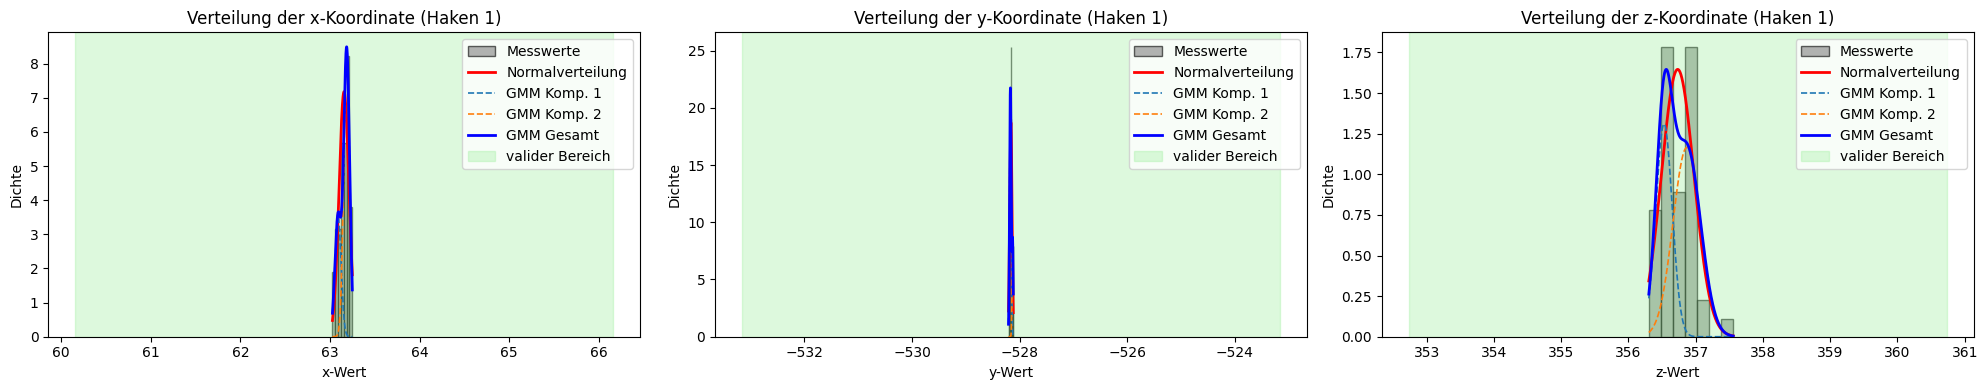

x-Achse: μ-Komponenten = [63.09 63.19], σ-Komponenten = [0.03 0.03], Gewichte = [0.3 0.7]
Zielbereich (angepasst): [60.16, 66.16] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-528.17 -528.13], σ-Komponenten = [0.01 0.01], Gewichte = [0.79 0.21]
Zielbereich (angepasst): [-533.16, -523.16] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [356.53 356.87], σ-Komponenten = [0.12 0.21], Gewichte = [0.4 0.6]
Zielbereich (angepasst): [352.73, 360.73] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  2


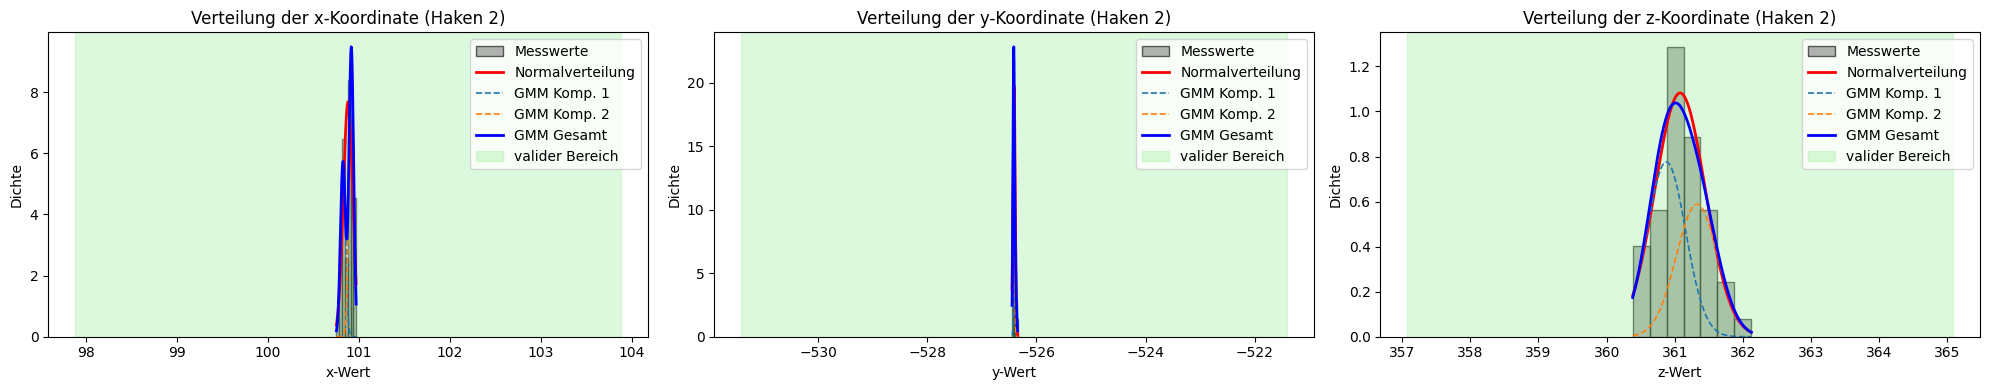

x-Achse: μ-Komponenten = [100.82 100.92], σ-Komponenten = [0.03 0.03], Gewichte = [0.39 0.61]
Zielbereich (angepasst): [97.88, 103.88] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-526.39 -526.42], σ-Komponenten = [0.02 0.01], Gewichte = [0.27 0.73]
Zielbereich (angepasst): [-531.41, -521.41] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [360.88 361.33], σ-Komponenten = [0.28 0.3 ], Gewichte = [0.55 0.45]
Zielbereich (angepasst): [357.08, 365.08] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  3


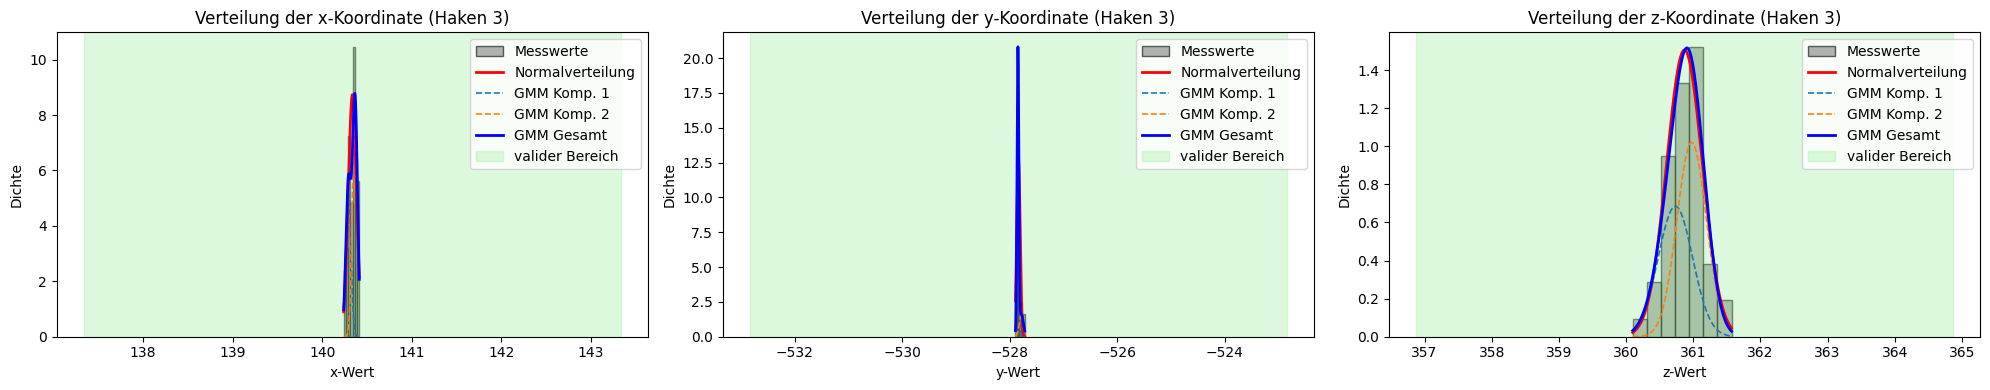

x-Achse: μ-Komponenten = [140.29 140.37], σ-Komponenten = [0.03 0.03], Gewichte = [0.39 0.61]
Zielbereich (angepasst): [137.34, 143.34] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-527.85 -527.79], σ-Komponenten = [0.02 0.04], Gewichte = [0.85 0.15]
Zielbereich (angepasst): [-532.84, -522.84] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [360.74 360.98], σ-Komponenten = [0.26 0.22], Gewichte = [0.44 0.56]
Zielbereich (angepasst): [356.87, 364.87] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  4


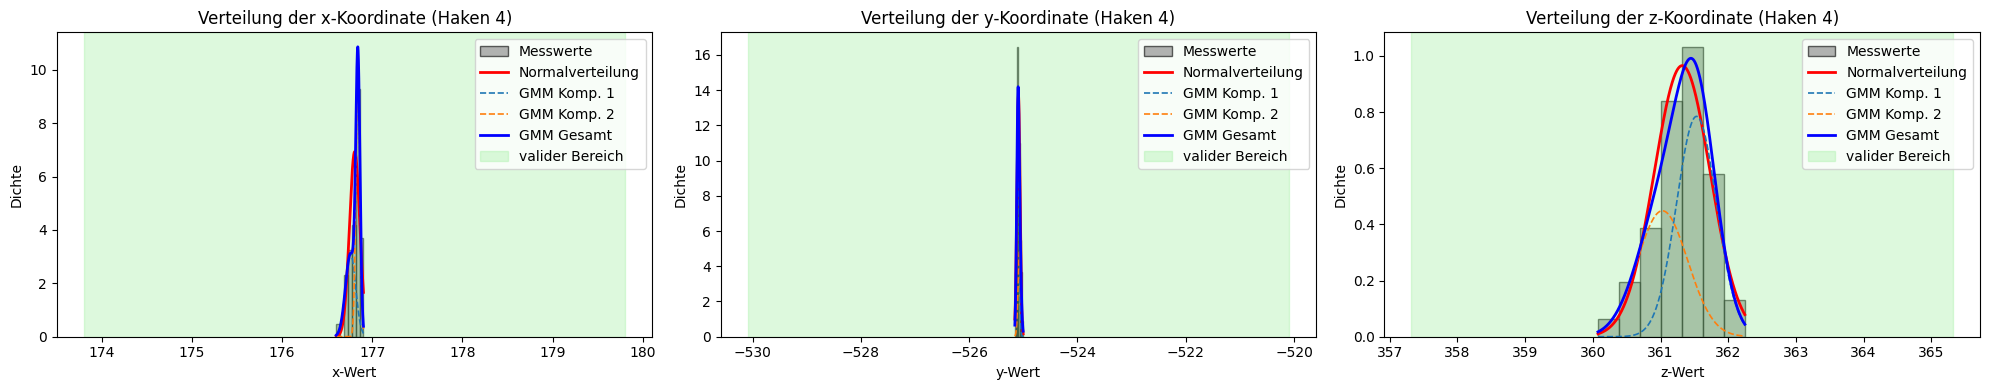

x-Achse: μ-Komponenten = [176.76 176.84], σ-Komponenten = [0.06 0.02], Gewichte = [0.44 0.56]
Zielbereich (angepasst): [173.81, 179.81] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-525.1  -525.07], σ-Komponenten = [0.02 0.03], Gewichte = [0.66 0.34]
Zielbereich (angepasst): [-530.09, -520.09] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [361.53 361.03], σ-Komponenten = [0.3  0.37], Gewichte = [0.58 0.42]
Zielbereich (angepasst): [357.32, 365.32] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  5


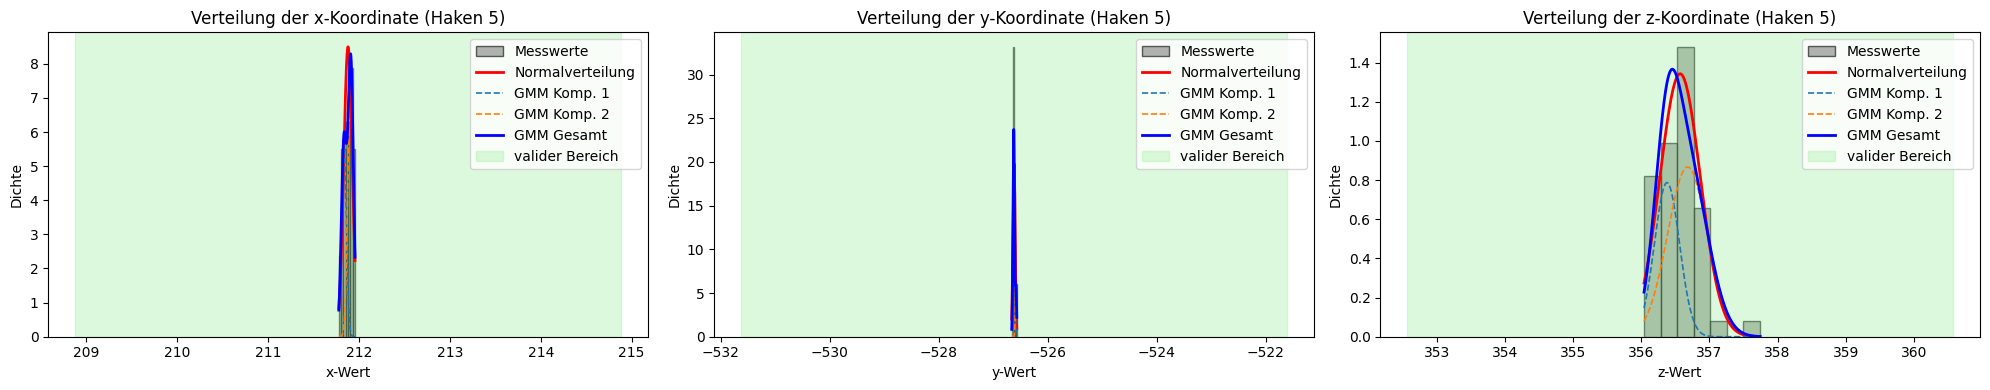

x-Achse: μ-Komponenten = [211.83 211.91], σ-Komponenten = [0.03 0.03], Gewichte = [0.39 0.61]
Zielbereich (angepasst): [208.88, 214.88] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-526.62 -526.58], σ-Komponenten = [0.01 0.01], Gewichte = [0.85 0.15]
Zielbereich (angepasst): [-531.62, -521.62] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [356.38 356.68], σ-Komponenten = [0.18 0.29], Gewichte = [0.36 0.64]
Zielbereich (angepasst): [352.57, 360.57] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  6


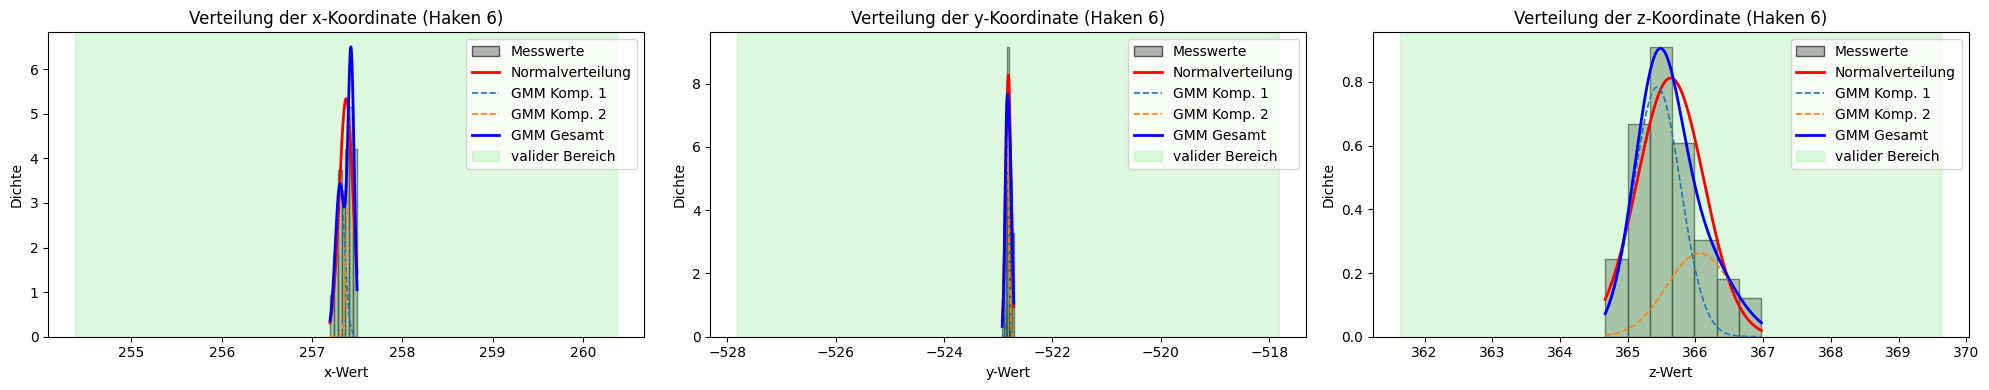

x-Achse: μ-Komponenten = [257.31 257.43], σ-Komponenten = [0.05 0.04], Gewichte = [0.44 0.56]
Zielbereich (angepasst): [254.38, 260.38] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-522.78 -522.84], σ-Komponenten = [0.04 0.03], Gewichte = [0.45 0.55]
Zielbereich (angepasst): [-527.81, -517.81] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [365.43 366.06], σ-Komponenten = [0.35 0.48], Gewichte = [0.68 0.32]
Zielbereich (angepasst): [361.63, 369.63] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  7


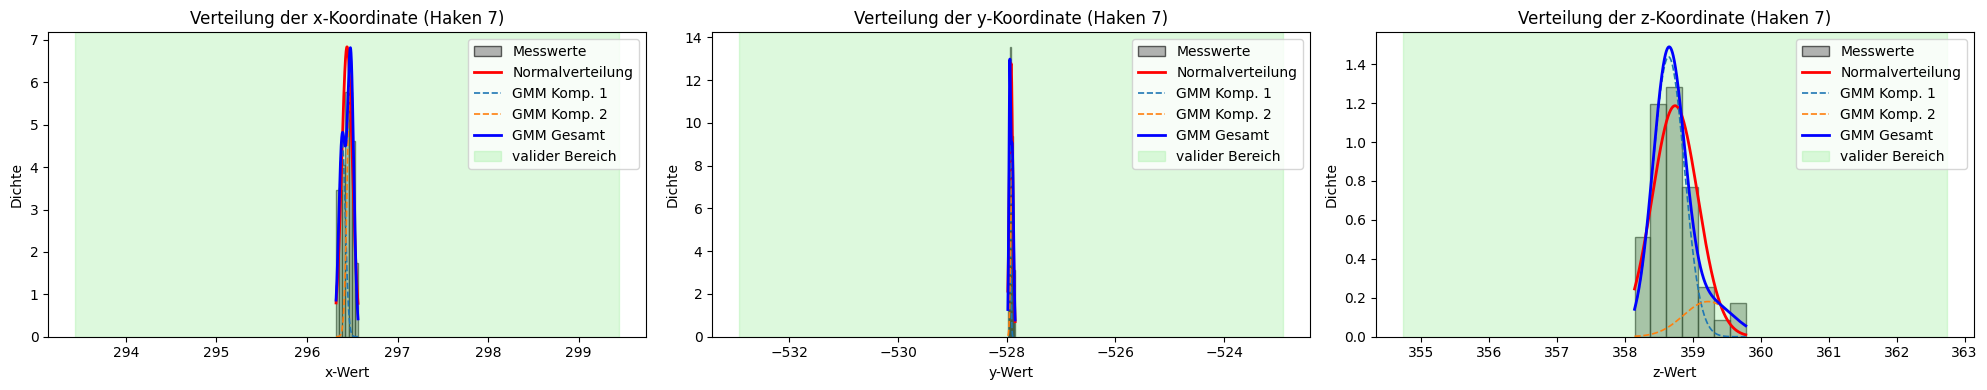

x-Achse: μ-Komponenten = [296.39 296.48], σ-Komponenten = [0.04 0.03], Gewichte = [0.42 0.58]
Zielbereich (angepasst): [293.44, 299.44] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-527.95 -527.9 ], σ-Komponenten = [0.02 0.02], Gewichte = [0.46 0.54]
Zielbereich (angepasst): [-532.92, -522.92] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [358.64 359.22], σ-Komponenten = [0.23 0.36], Gewichte = [0.84 0.16]
Zielbereich (angepasst): [354.74, 362.74] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  8


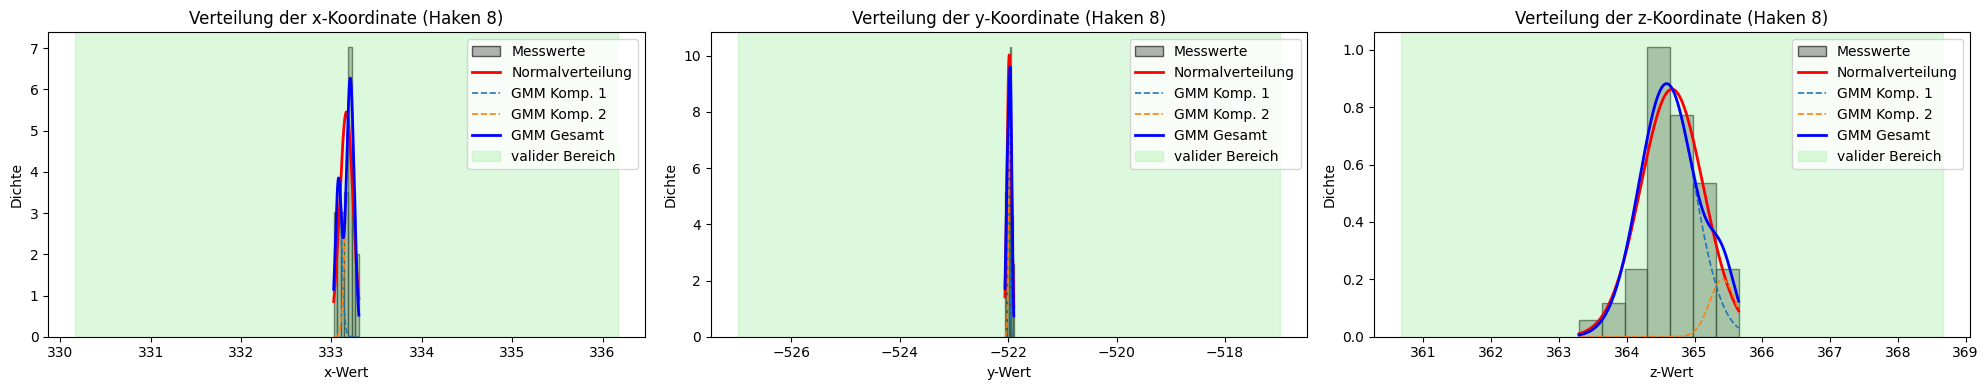

x-Achse: μ-Komponenten = [333.08 333.21], σ-Komponenten = [0.03 0.04], Gewichte = [0.33 0.67]
Zielbereich (angepasst): [330.17, 336.17] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-522.01 -521.96], σ-Komponenten = [0.03 0.03], Gewichte = [0.43 0.57]
Zielbereich (angepasst): [-526.98, -516.98] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [364.59 365.41], σ-Komponenten = [0.41 0.19], Gewichte = [0.9 0.1]
Zielbereich (angepasst): [360.67, 368.67] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  9


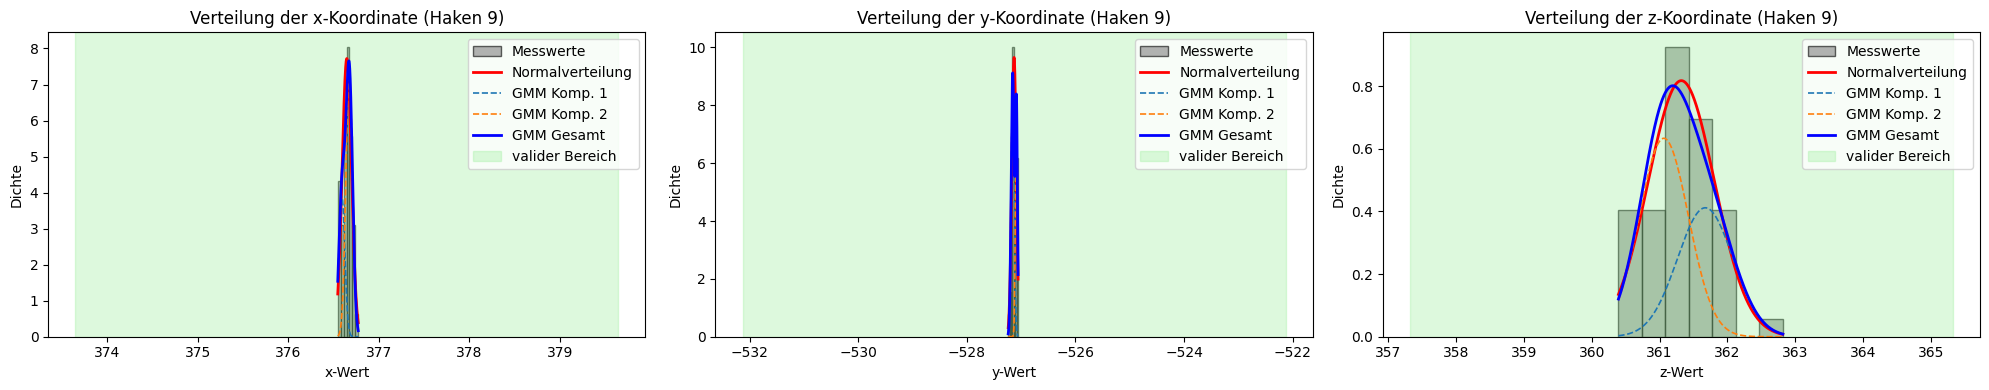

x-Achse: μ-Komponenten = [376.59 376.67], σ-Komponenten = [0.03 0.04], Gewichte = [0.32 0.68]
Zielbereich (angepasst): [373.65, 379.65] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-527.16 -527.09], σ-Komponenten = [0.03 0.02], Gewichte = [0.63 0.37]
Zielbereich (angepasst): [-532.13, -522.13] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [361.67 361.06], σ-Komponenten = [0.41 0.36], Gewichte = [0.42 0.58]
Zielbereich (angepasst): [357.32, 365.32] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  10


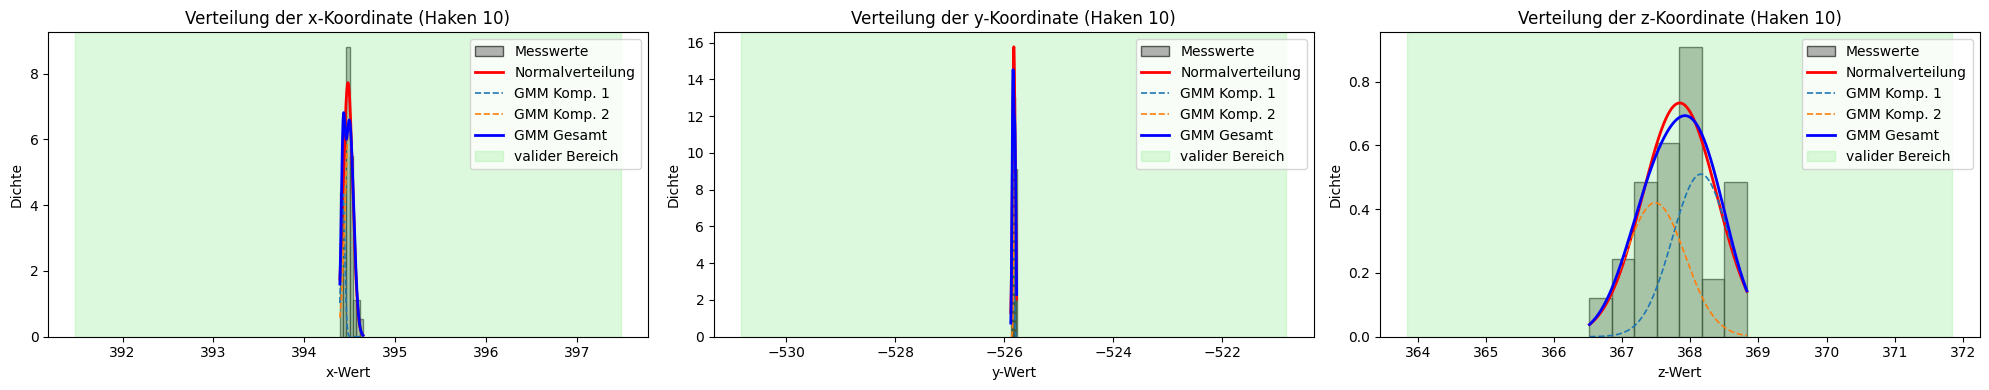

x-Achse: μ-Komponenten = [394.43 394.5 ], σ-Komponenten = [0.02 0.05], Gewichte = [0.22 0.78]
Zielbereich (angepasst): [391.48, 397.48] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-525.84 -525.8 ], σ-Komponenten = [0.02 0.02], Gewichte = [0.54 0.46]
Zielbereich (angepasst): [-530.82, -520.82] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [368.16 367.48], σ-Komponenten = [0.42 0.44], Gewichte = [0.54 0.46]
Zielbereich (angepasst): [363.84, 371.84] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  11


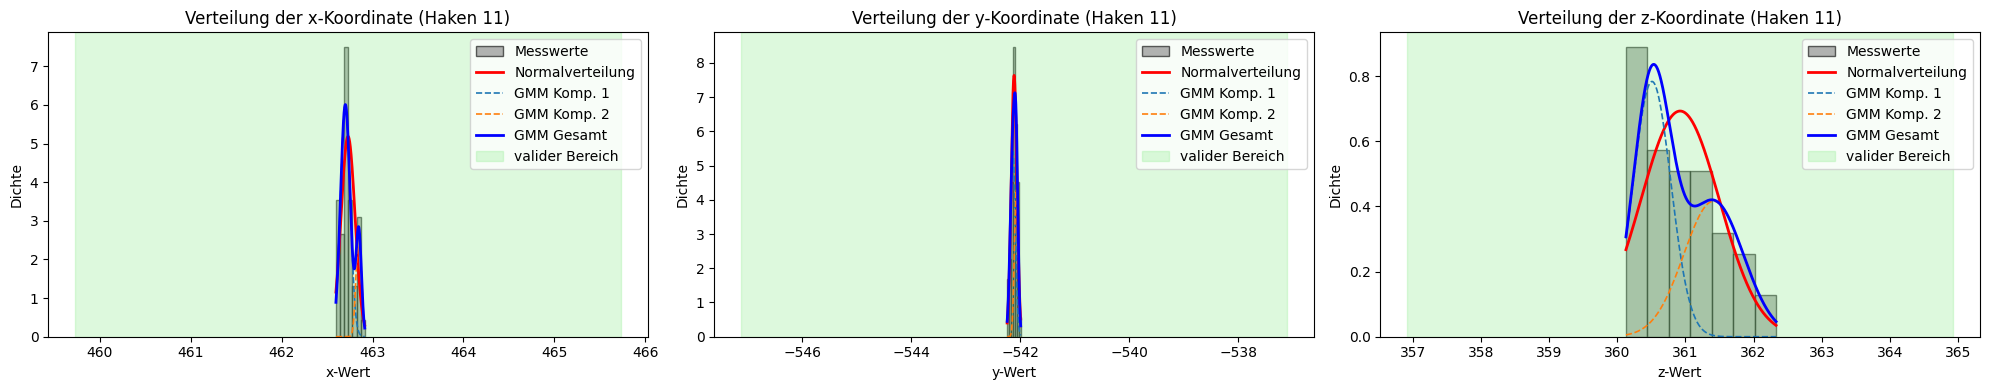

x-Achse: μ-Komponenten = [462.7  462.85], σ-Komponenten = [0.05 0.03], Gewichte = [0.8 0.2]
Zielbereich (angepasst): [459.73, 465.73] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-542.14 -542.08], σ-Komponenten = [0.05 0.03], Gewichte = [0.63 0.37]
Zielbereich (angepasst): [-547.12, -537.12] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [360.51 361.41], σ-Komponenten = [0.28 0.44], Gewichte = [0.54 0.46]
Zielbereich (angepasst): [356.92, 364.92] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  12


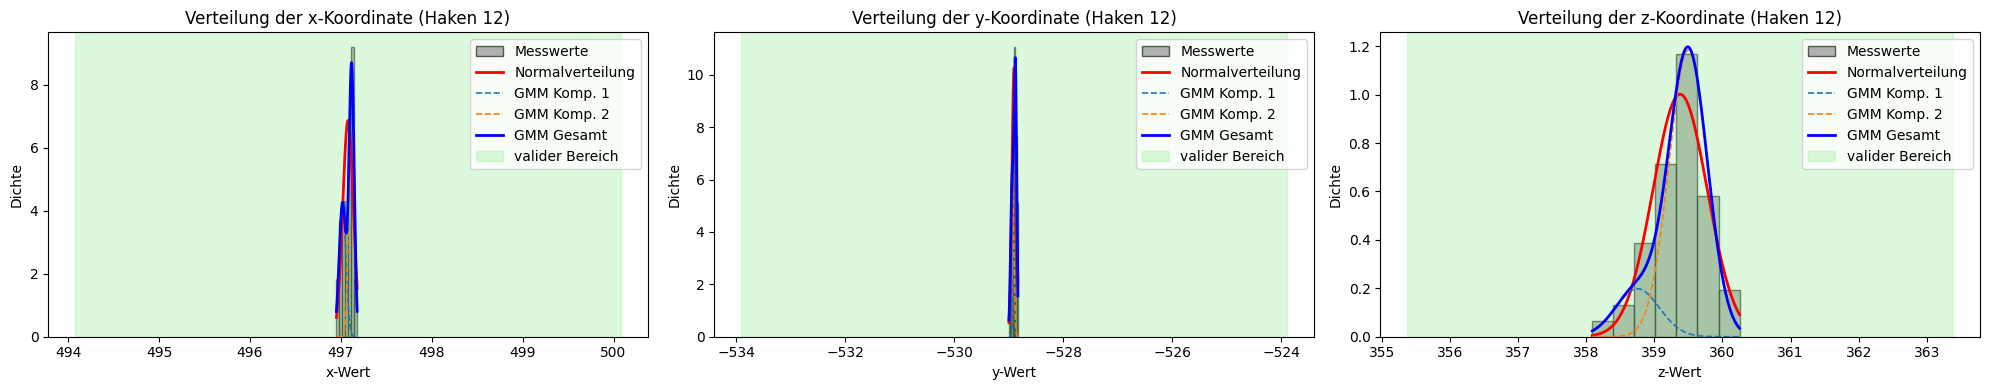

x-Achse: μ-Komponenten = [497.02 497.12], σ-Komponenten = [0.04 0.03], Gewichte = [0.39 0.61]
Zielbereich (angepasst): [494.08, 500.08] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-528.88 -528.94], σ-Komponenten = [0.02 0.03], Gewichte = [0.58 0.42]
Zielbereich (angepasst): [-533.90, -523.90] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [358.75 359.5 ], σ-Komponenten = [0.32 0.28], Gewichte = [0.16 0.84]
Zielbereich (angepasst): [355.38, 363.38] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  13


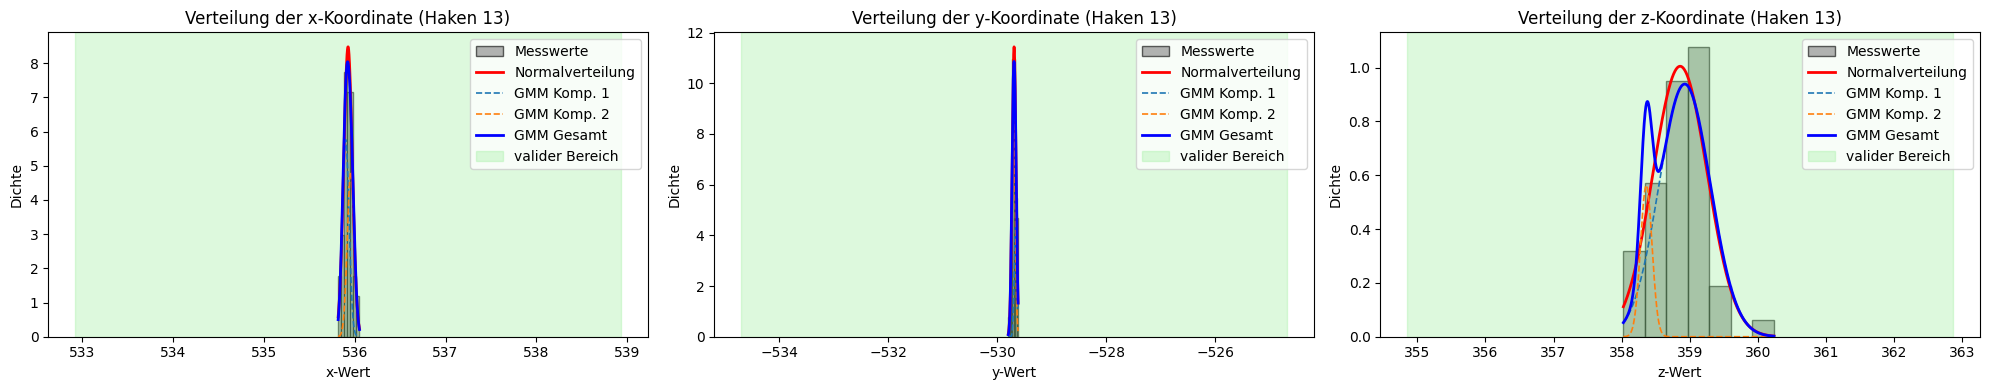

x-Achse: μ-Komponenten = [535.9  535.96], σ-Komponenten = [0.04 0.04], Gewichte = [0.54 0.46]
Zielbereich (angepasst): [532.93, 538.93] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-529.66 -529.71], σ-Komponenten = [0.03 0.03], Gewichte = [0.28 0.72]
Zielbereich (angepasst): [-534.69, -524.69] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [358.92 358.36], σ-Komponenten = [0.37 0.08], Gewichte = [0.88 0.12]
Zielbereich (angepasst): [354.86, 362.86] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  14


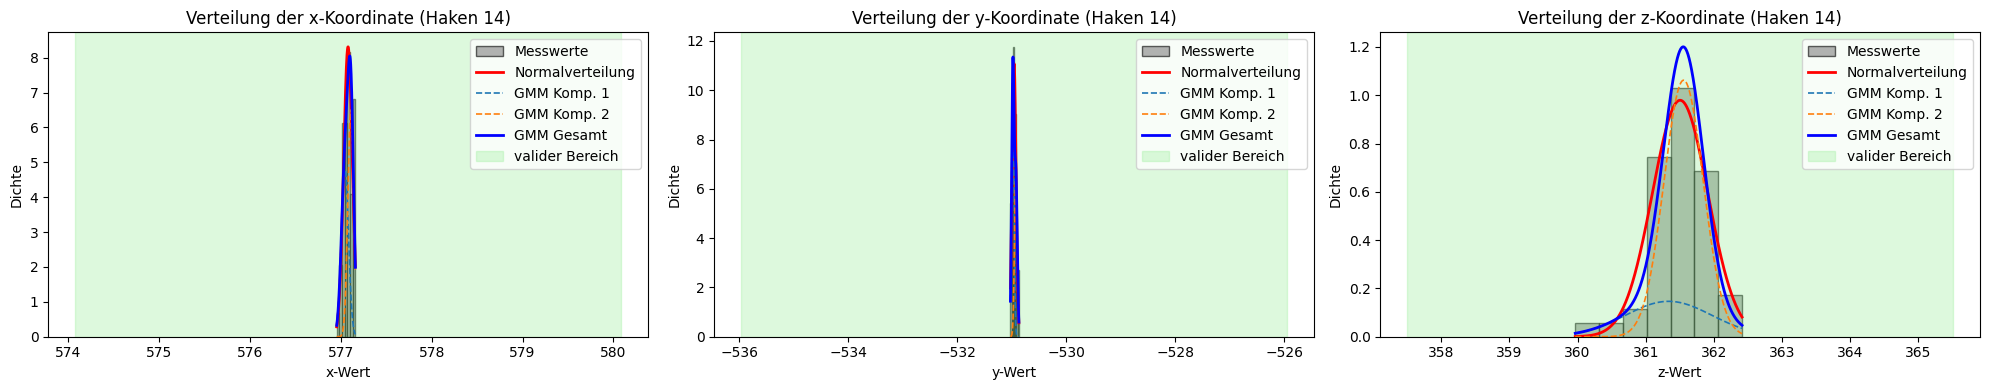

x-Achse: μ-Komponenten = [577.05 577.11], σ-Komponenten = [0.04 0.03], Gewichte = [0.47 0.53]
Zielbereich (angepasst): [574.08, 580.08] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-530.98 -530.92], σ-Komponenten = [0.02 0.03], Gewichte = [0.59 0.41]
Zielbereich (angepasst): [-535.96, -525.96] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [361.34 361.56], σ-Komponenten = [0.63 0.29], Gewichte = [0.23 0.77]
Zielbereich (angepasst): [357.50, 365.50] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  15


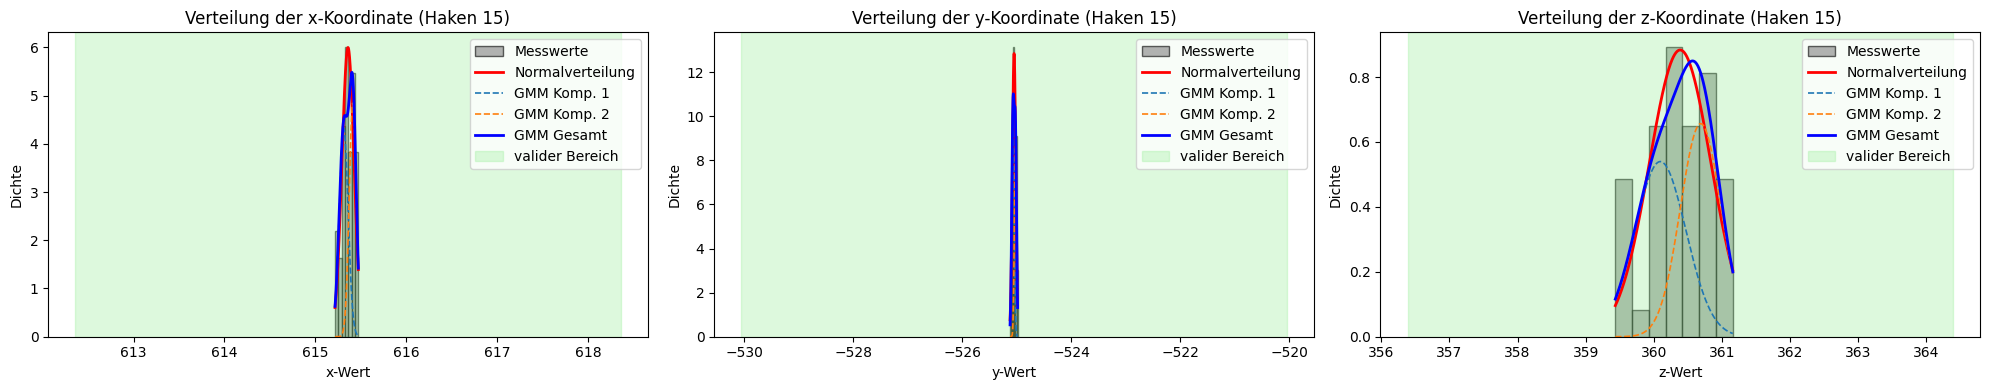

x-Achse: μ-Komponenten = [615.31 615.41], σ-Komponenten = [0.05 0.04], Gewichte = [0.53 0.47]
Zielbereich (angepasst): [612.36, 618.36] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-525.07 -525.02], σ-Komponenten = [0.02 0.02], Gewichte = [0.57 0.43]
Zielbereich (angepasst): [-530.05, -520.05] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [360.09 360.69], σ-Komponenten = [0.38 0.3 ], Gewichte = [0.51 0.49]
Zielbereich (angepasst): [356.39, 364.39] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  16


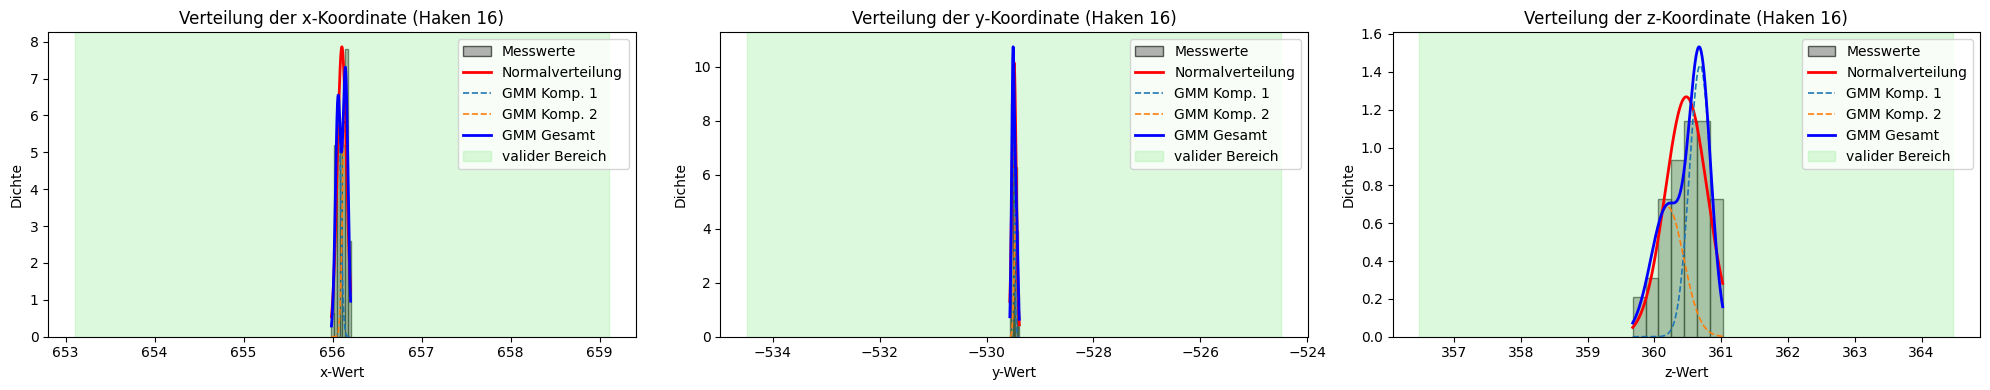

x-Achse: μ-Komponenten = [656.06 656.14], σ-Komponenten = [0.03 0.03], Gewichte = [0.48 0.52]
Zielbereich (angepasst): [653.10, 659.10] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-529.51 -529.45], σ-Komponenten = [0.03 0.03], Gewichte = [0.62 0.38]
Zielbereich (angepasst): [-534.49, -524.49] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [360.68 360.19], σ-Komponenten = [0.16 0.24], Gewichte = [0.58 0.42]
Zielbereich (angepasst): [356.48, 364.48] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  17


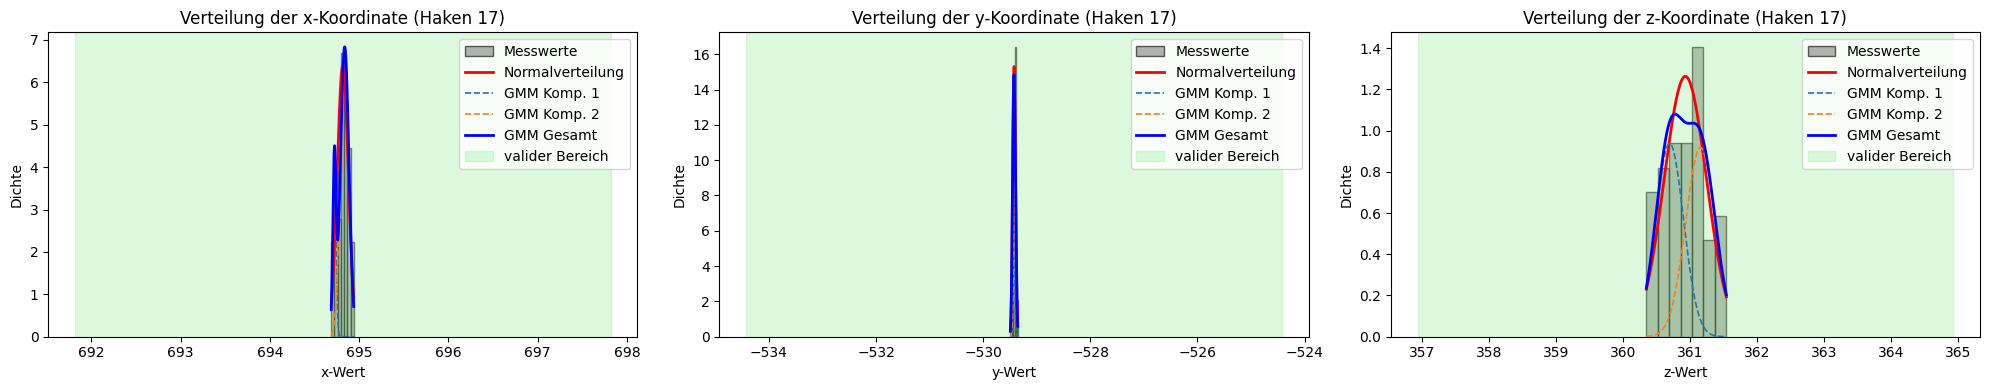

x-Achse: μ-Komponenten = [694.72 694.84], σ-Komponenten = [0.02 0.05], Gewichte = [0.19 0.81]
Zielbereich (angepasst): [691.82, 697.82] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-529.44 -529.41], σ-Komponenten = [0.02 0.02], Gewichte = [0.5 0.5]
Zielbereich (angepasst): [-534.42, -524.42] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [360.7  361.16], σ-Komponenten = [0.21 0.22], Gewichte = [0.49 0.51]
Zielbereich (angepasst): [356.93, 364.93] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  18


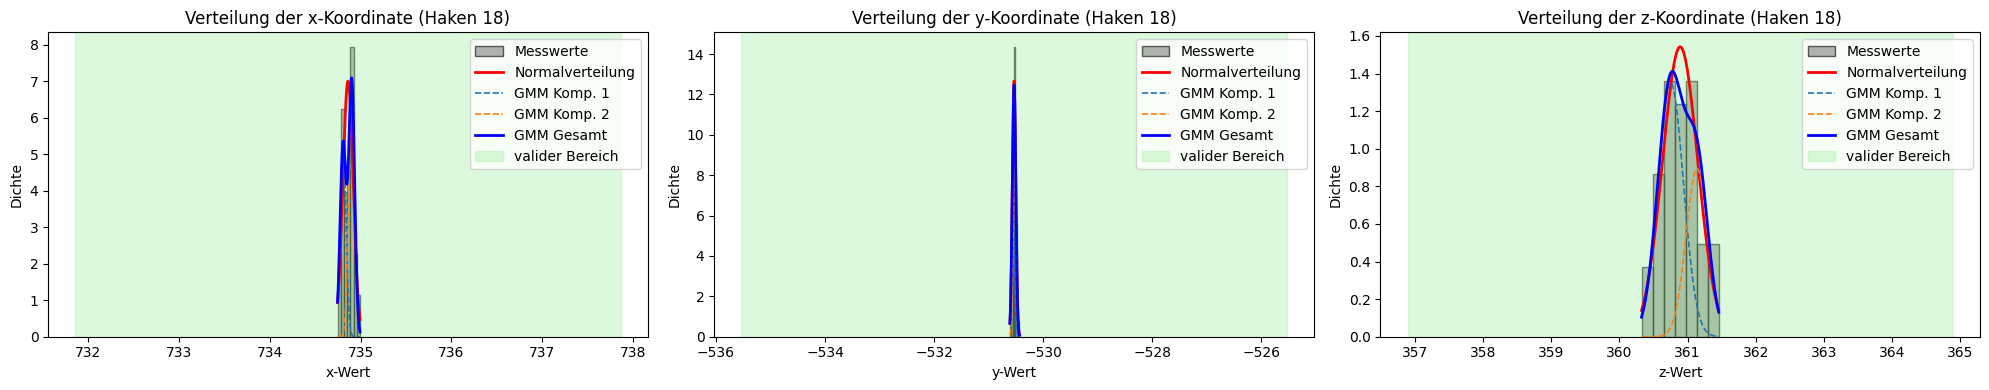

x-Achse: μ-Komponenten = [734.81 734.9 ], σ-Komponenten = [0.03 0.03], Gewichte = [0.43 0.57]
Zielbereich (angepasst): [731.86, 737.86] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-530.55 -530.52], σ-Komponenten = [0.03 0.03], Gewichte = [0.4 0.6]
Zielbereich (angepasst): [-535.53, -525.53] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [360.75 361.14], σ-Komponenten = [0.19 0.16], Gewichte = [0.64 0.36]
Zielbereich (angepasst): [356.89, 364.89] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  19


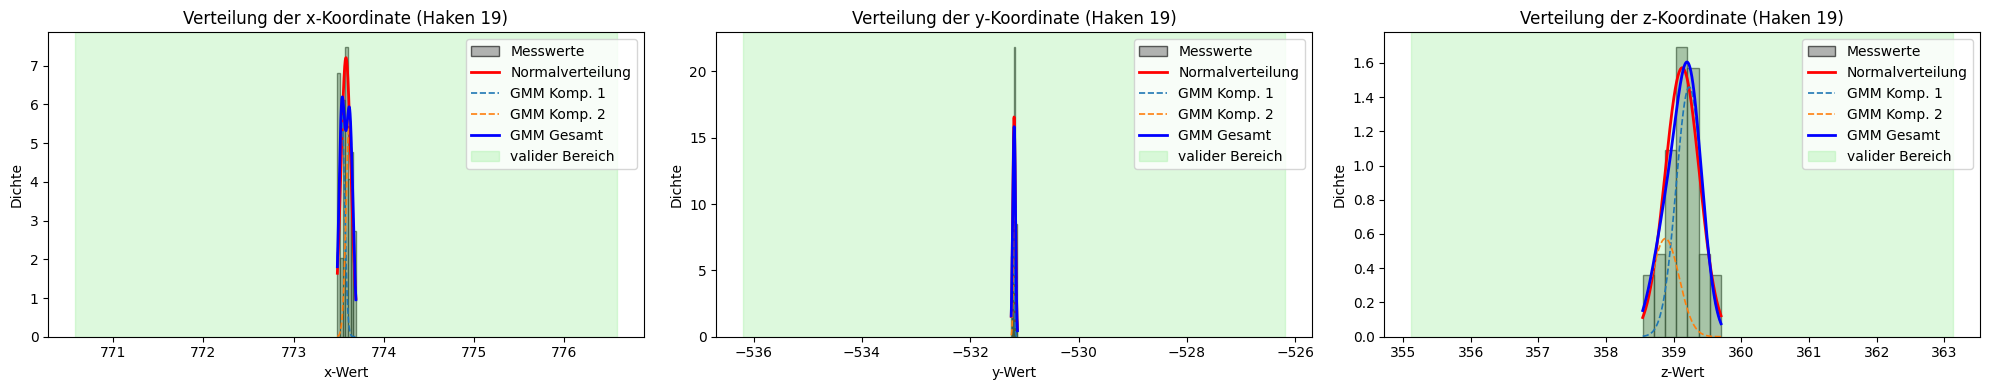

x-Achse: μ-Komponenten = [773.53 773.62], σ-Komponenten = [0.03 0.04], Gewichte = [0.47 0.53]
Zielbereich (angepasst): [770.58, 776.58] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-531.21 -531.18], σ-Komponenten = [0.02 0.02], Gewichte = [0.36 0.64]
Zielbereich (angepasst): [-536.19, -526.19] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [359.23 358.88], σ-Komponenten = [0.19 0.2 ], Gewichte = [0.71 0.29]
Zielbereich (angepasst): [355.12, 363.12] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  20


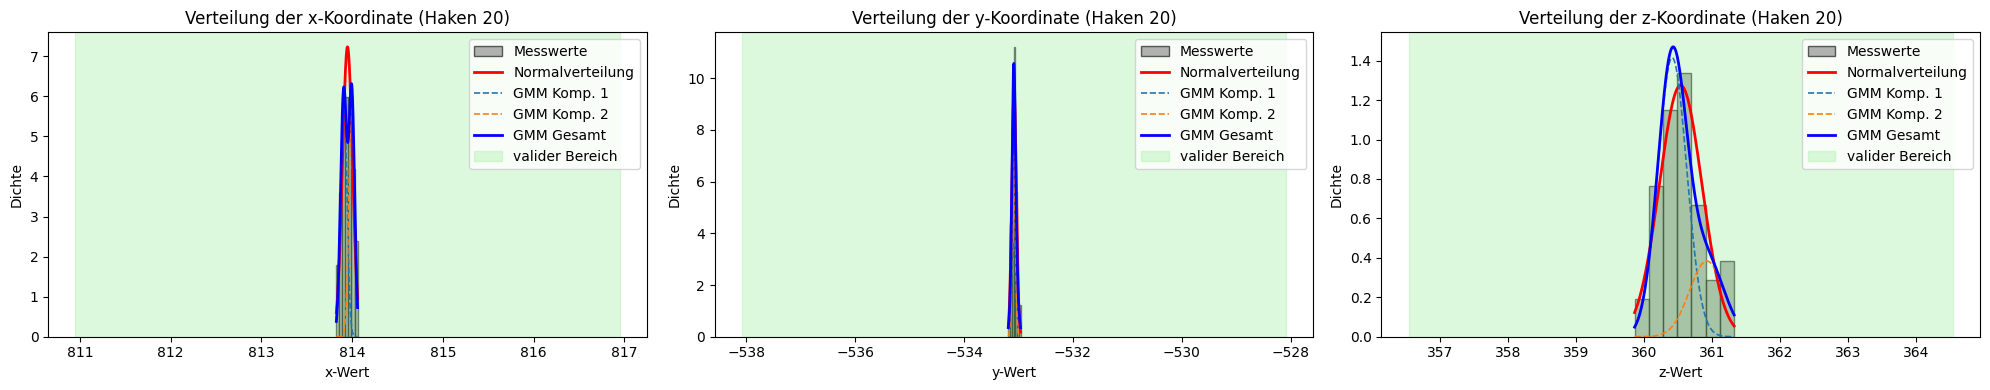

x-Achse: μ-Komponenten = [813.91 814.  ], σ-Komponenten = [0.03 0.03], Gewichte = [0.53 0.47]
Zielbereich (angepasst): [810.95, 816.95] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-533.07 -533.09], σ-Komponenten = [0.05 0.03], Gewichte = [0.47 0.53]
Zielbereich (angepasst): [-538.08, -528.08] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [360.41 360.92], σ-Komponenten = [0.21 0.25], Gewichte = [0.76 0.24]
Zielbereich (angepasst): [356.53, 364.53] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  21


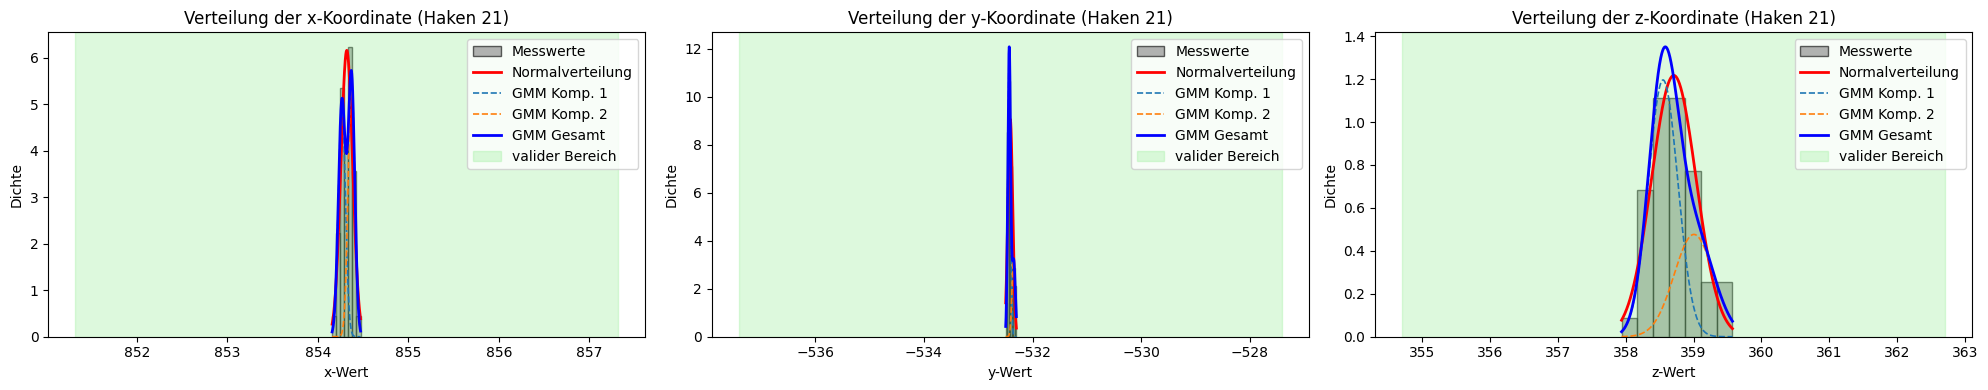

x-Achse: μ-Komponenten = [854.26 854.37], σ-Komponenten = [0.04 0.04], Gewichte = [0.49 0.51]
Zielbereich (angepasst): [851.32, 857.32] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-532.43 -532.35], σ-Komponenten = [0.03 0.03], Gewichte = [0.75 0.25]
Zielbereich (angepasst): [-537.41, -527.41] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [358.55 359.  ], σ-Komponenten = [0.22 0.29], Gewichte = [0.65 0.35]
Zielbereich (angepasst): [354.71, 362.71] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  22


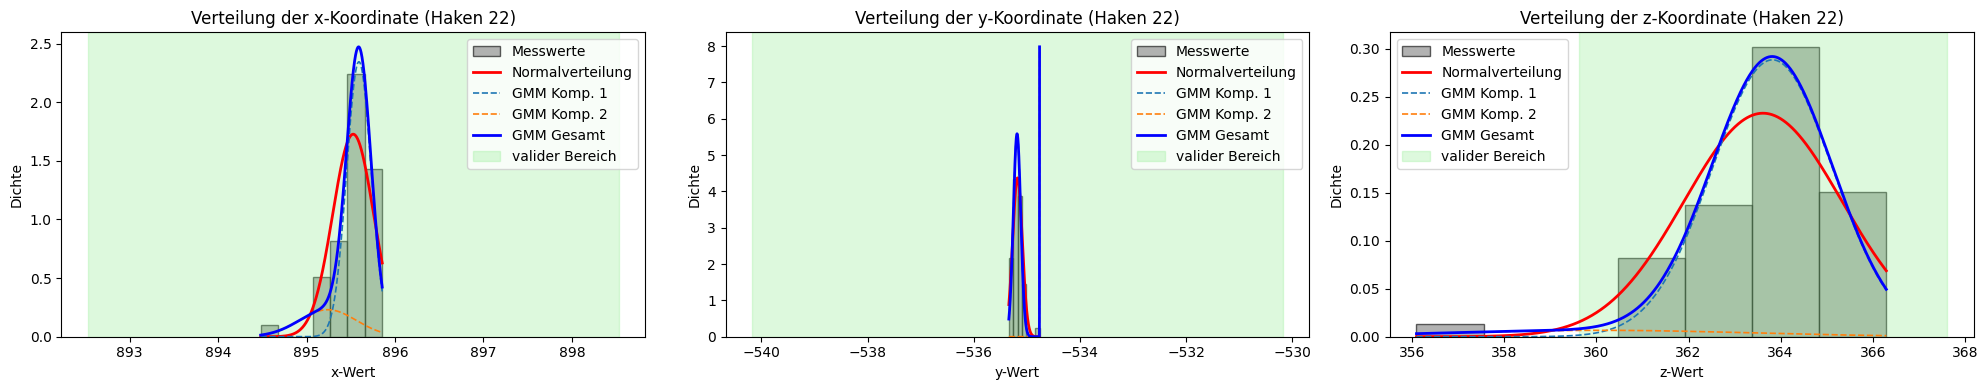

x-Achse: μ-Komponenten = [895.59 895.24], σ-Komponenten = [0.14 0.32], Gewichte = [0.81 0.19]
Zielbereich (angepasst): [892.53, 898.53] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-535.18 -534.76], σ-Komponenten = [0.07 0.  ], Gewichte = [0.98 0.02]
Zielbereich (angepasst): [-540.18, -530.18] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [363.82 360.08], σ-Komponenten = [1.31 3.29], Gewichte = [0.95 0.05]
Zielbereich (angepasst): [359.62, 367.62] → Wahrscheinlichkeit = 97.26 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 97.26 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  23


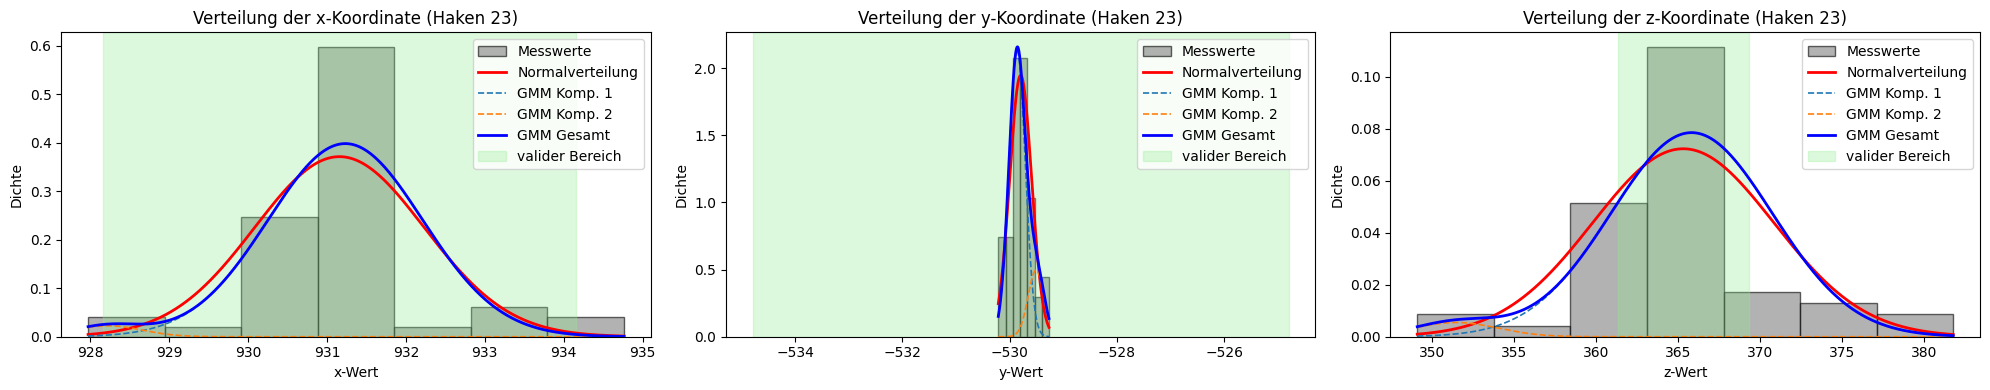

x-Achse: μ-Komponenten = [931.23 928.22], σ-Komponenten = [0.98 0.44], Gewichte = [0.98 0.02]
Zielbereich (angepasst): [928.16, 934.16] → Wahrscheinlichkeit = 98.70 %

y-Achse: μ-Komponenten = [-529.86 -529.51], σ-Komponenten = [0.15 0.15], Gewichte = [0.81 0.19]
Zielbereich (angepasst): [-534.80, -524.80] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [365.82 351.46], σ-Komponenten = [4.9  2.58], Gewichte = [0.96 0.04]
Zielbereich (angepasst): [361.32, 369.32] → Wahrscheinlichkeit = 56.23 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 55.49 %

Durchschnittliche Verteilungs-Mittelwerte - XYZ:  495.3766903818943 -529.0260034561317 361.1055391194366
Durchschnittliche Standardabweichungen - XYZ:  0.10931132286599367 0.04366508259299856 0.6589599743180378


In [12]:
mu_x_mean = 0
mu_y_mean = 0
mu_z_mean = 0

std_x_mean = 0
std_y_mean = 0
std_z_mean = 0

for hook_num in range(len(dicts_list[0])):
    mu_std_results, probs = plot_prob_and_hist(hook_num+1, dicts_list)
    
    mu_x_mean += mu_std_results['x'][0]
    mu_y_mean += mu_std_results['y'][0]
    mu_z_mean += mu_std_results['z'][0]
    
    std_x_mean += mu_std_results['x'][1]
    std_y_mean += mu_std_results['y'][1]
    std_z_mean += mu_std_results['z'][1]

mu_x_mean /= len(dicts_list[0])
mu_y_mean /= len(dicts_list[0])
mu_z_mean /= len(dicts_list[0])

std_x_mean /= len(dicts_list[0])
std_y_mean /= len(dicts_list[0])
std_z_mean /= len(dicts_list[0])

print("Durchschnittliche Verteilungs-Mittelwerte - XYZ: ", mu_x_mean, mu_y_mean, mu_z_mean)
print("Durchschnittliche Standardabweichungen - XYZ: ", std_x_mean, std_y_mean, std_z_mean)

***
## **Geschwindigkeitsvariationen**

**Dicts laden**

In [12]:
dir_path = '/home/mo/Thesis/Evaluation/1_Scan-Prozess/2_Geschwindigkeit'

In [13]:
dicts_list = []

for testrun_folder in sorted(os.listdir(dir_path)):
    testrun_folder_path = os.path.join(dir_path, testrun_folder)

    if os.path.isdir(testrun_folder_path) and testrun_folder.isdigit():
        data = os.listdir(testrun_folder_path)
        csv_data = [f for f in data if f.endswith('.csv')]

        if len(csv_data) == 1:
            csv_path = os.path.join(testrun_folder_path, csv_data[0])
            dicts_list.append(load_csv_to_dict(csv_path))
        else:
            print(f"No CSV file in: {testrun_folder_path}")

print(f"{len(dicts_list)} Dictionaries found...")

No CSV file in: /home/mo/Thesis/Evaluation/1_Scan-Prozess/2_Geschwindigkeit/30
5 Dictionaries found...


**Plot erstellen für Koordinaten**

In [14]:
def plot_speed_values(dicts_list=None, speed_values=None):
    """
    Plottet die x, y, z-Werte für jeden Haken-Tip und -Lowpoint in einem 2x3 Plot.
    Links: Tip-Koordinaten (x, y, z)
    Rechts: Lowpoint-Koordinaten (x, y, z)
    Jeder Punkt wird farblich markiert je nach Ursprung aus dicts_list.
    Die Legende zeigt den Geschwindigkeitswert aus speed_values.
    """
    if dicts_list is None or speed_values is None:
        raise ValueError("dicts_list und speed_values dürfen nicht None sein.")

    if len(dicts_list) != len(speed_values):
        raise ValueError("dicts_list und speed_values müssen gleich lang sein.")

    num_hooks = len(dicts_list[0])
    num_samples = len(dicts_list)

    tips = np.zeros((num_hooks, num_samples, 3))
    lowpoints = np.zeros((num_hooks, num_samples, 3))

    for hook_idx in range(num_hooks):
        dict_key = str(hook_idx + 1)
        for sample_idx, d in enumerate(dicts_list):
            tips[hook_idx, sample_idx] = d[dict_key]['xyz_tip_in_workframe']
            lowpoints[hook_idx, sample_idx] = d[dict_key]['xyz_lowpoint_in_workframe']

    cmap = cm.get_cmap('viridis', num_samples)
    colors = [cmap(i) for i in range(num_samples)]

    fig, axs = plt.subplots(3, 2, figsize=(20, 12))
    fig.suptitle('Koordinaten bei Variation der translatorischen Geschwindigkeit', fontsize=16)
    coord_labels = ['x', 'y', 'z']

    for i in range(3):
        for sample_idx in range(num_samples):
            speed = speed_values[sample_idx]

            axs[i, 0].plot(np.arange(1, num_hooks + 1),
                          tips[:, sample_idx, i],
                          'o-', color=colors[sample_idx], alpha=0.6,
                          label=f'v = {speed}')

            axs[i, 1].plot(np.arange(1, num_hooks + 1),
                          lowpoints[:, sample_idx, i],
                          'o-', color=colors[sample_idx], alpha=0.6,
                          label=f'v = {speed}')

        axs[i, 0].set_ylabel(f'Spitze {coord_labels[i]}')
        axs[i, 1].set_ylabel(f'Senke {coord_labels[i]}')
        axs[i, 0].grid()
        axs[i, 1].grid()
        axs[i, 0].legend()
        axs[i, 1].legend()
        axs[i, 0].set_xlabel('Haken-Instanz')
        axs[i, 1].set_xlabel('Haken-Instanz')
        axs[0, 0].set_title('Spitze')
        axs[0, 1].set_title('Senke')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

/tmp/ipykernel_21342/2454348445.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', num_samples)


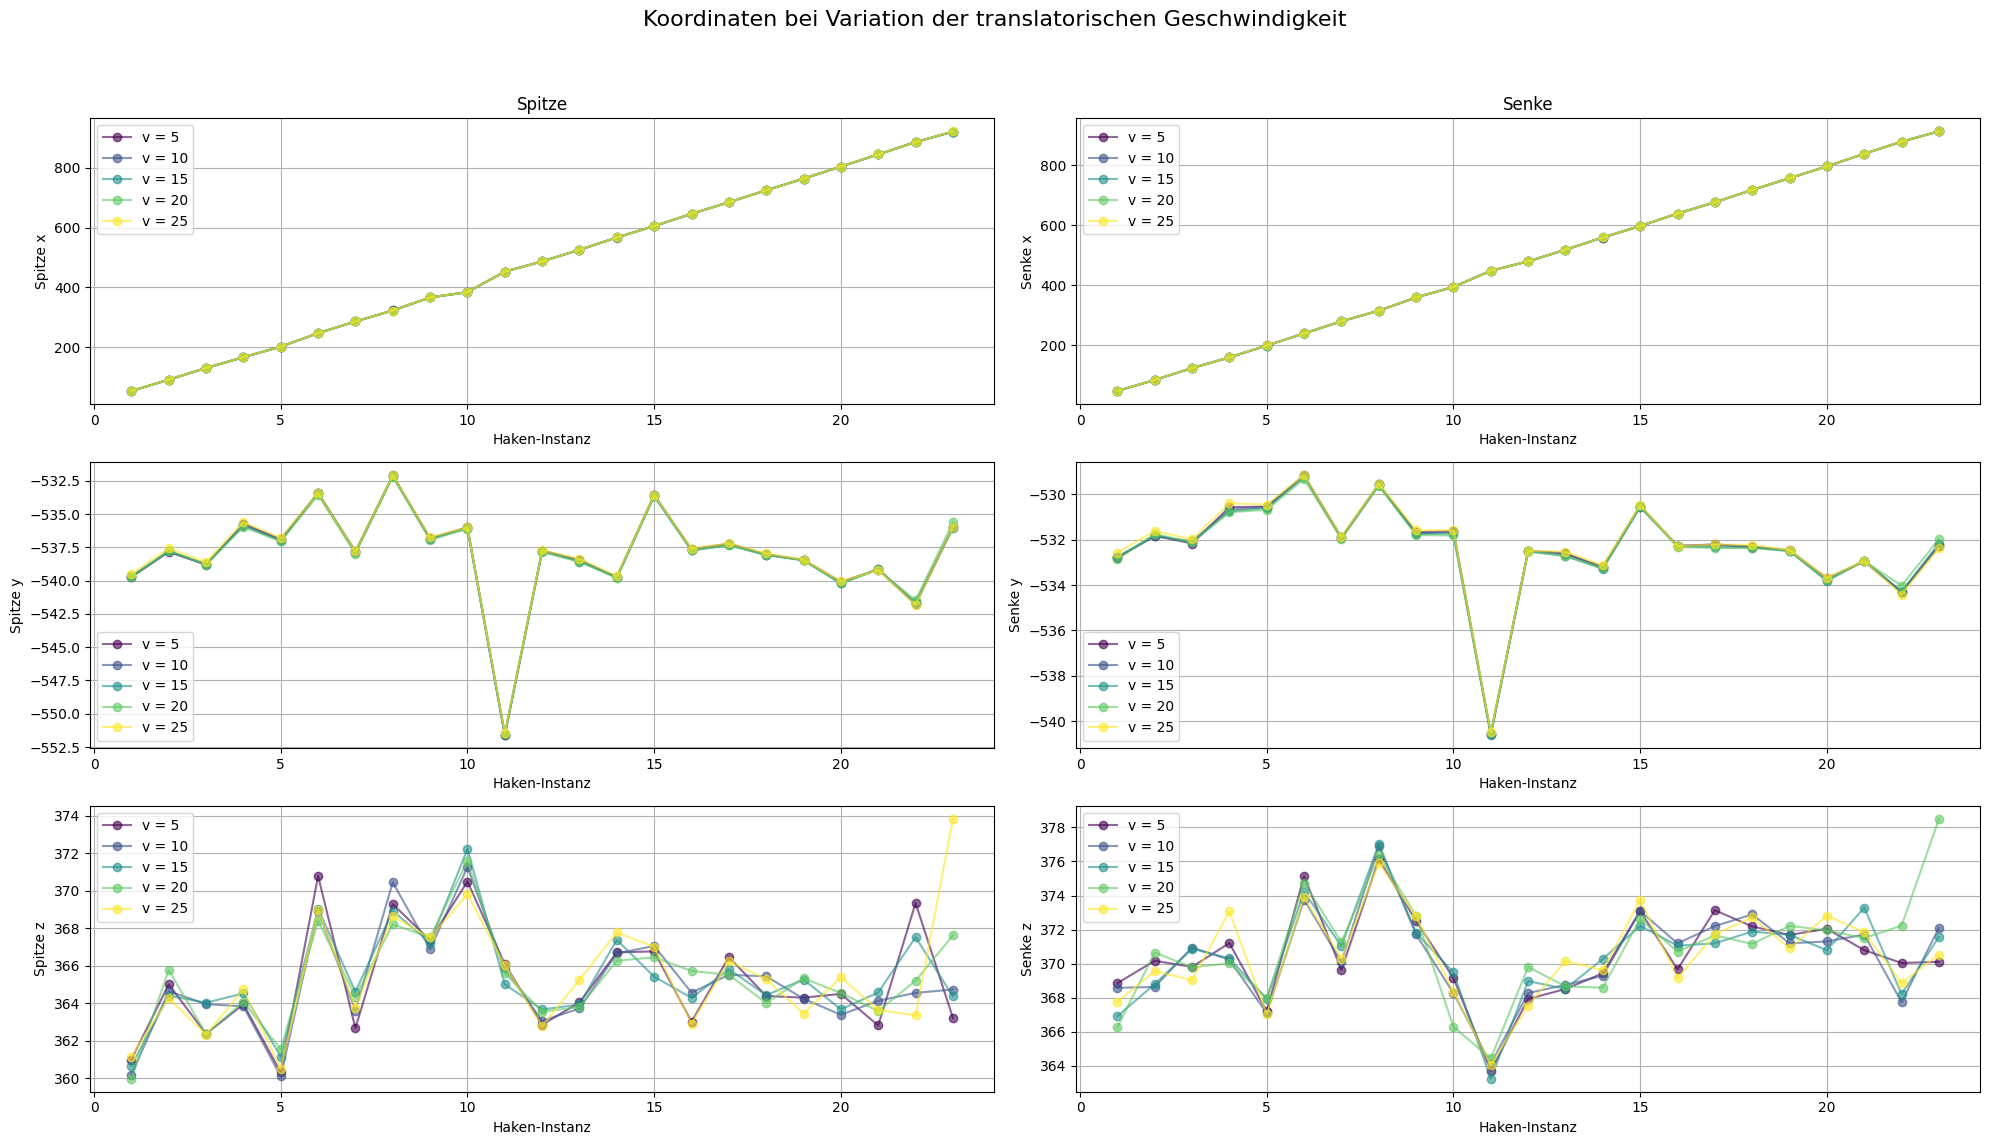

In [15]:
plot_speed_values(dicts_list, [5, 10, 15, 20, 25])

**Mittelwert berechnen**

In [16]:
mean_xyz_tip_in_workframe, mean_xyz_lowpoint_in_workframe = calculate_mean(dicts_list)

**Standardabweichung und Verteilung berechnen**

---------------------------------------------------------------------------------------------------------
Daten für Haken  1


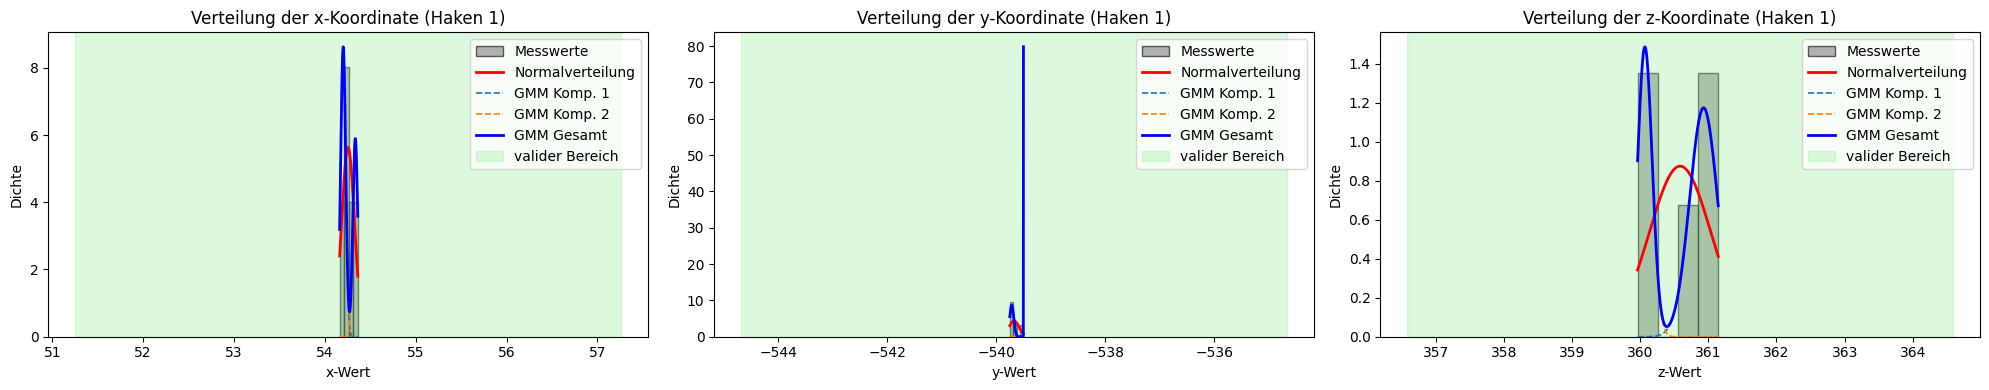

x-Achse: μ-Komponenten = [54.2  54.33], σ-Komponenten = [0.03 0.03], Gewichte = [0.6 0.4]
Zielbereich (angepasst): [51.25, 57.25] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-539.72 -539.5 ], σ-Komponenten = [0.04 0.  ], Gewichte = [0.8 0.2]
Zielbereich (angepasst): [-544.67, -534.67] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [360.93 360.07], σ-Komponenten = [0.2  0.11], Gewichte = [0.6 0.4]
Zielbereich (angepasst): [356.59, 364.59] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  2


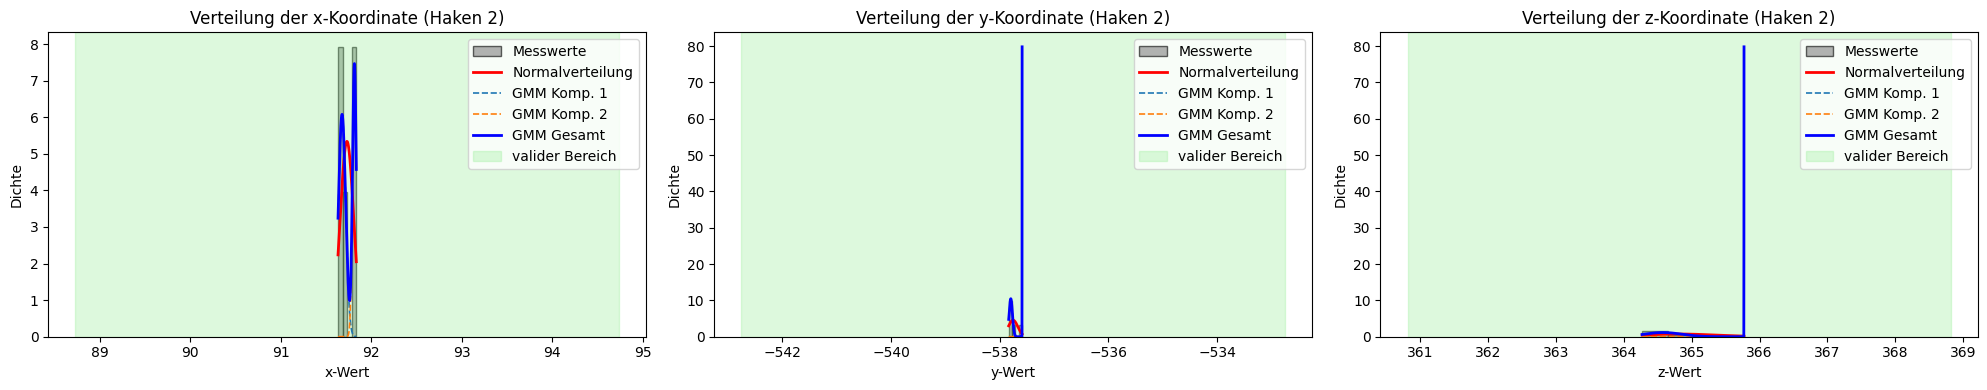

x-Achse: μ-Komponenten = [91.68 91.81], σ-Komponenten = [0.04 0.02], Gewichte = [0.6 0.4]
Zielbereich (angepasst): [88.73, 94.73] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-537.8  -537.59], σ-Komponenten = [0.03 0.  ], Gewichte = [0.8 0.2]
Zielbereich (angepasst): [-542.76, -532.76] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [364.58 365.77], σ-Komponenten = [0.28 0.  ], Gewichte = [0.8 0.2]
Zielbereich (angepasst): [360.82, 368.82] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  3


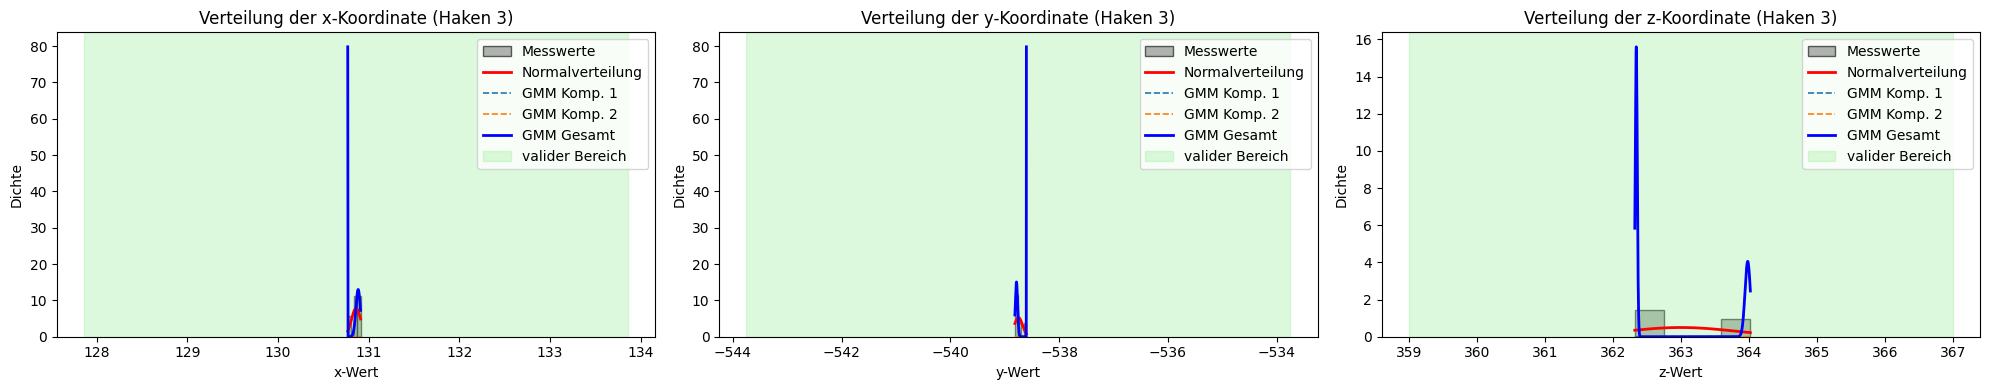

x-Achse: μ-Komponenten = [130.88 130.77], σ-Komponenten = [0.02 0.  ], Gewichte = [0.8 0.2]
Zielbereich (angepasst): [127.86, 133.86] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-538.79 -538.6 ], σ-Komponenten = [0.02 0.  ], Gewichte = [0.8 0.2]
Zielbereich (angepasst): [-543.75, -533.75] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [363.99 362.35], σ-Komponenten = [0.04 0.02], Gewichte = [0.4 0.6]
Zielbereich (angepasst): [359.00, 367.00] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  4


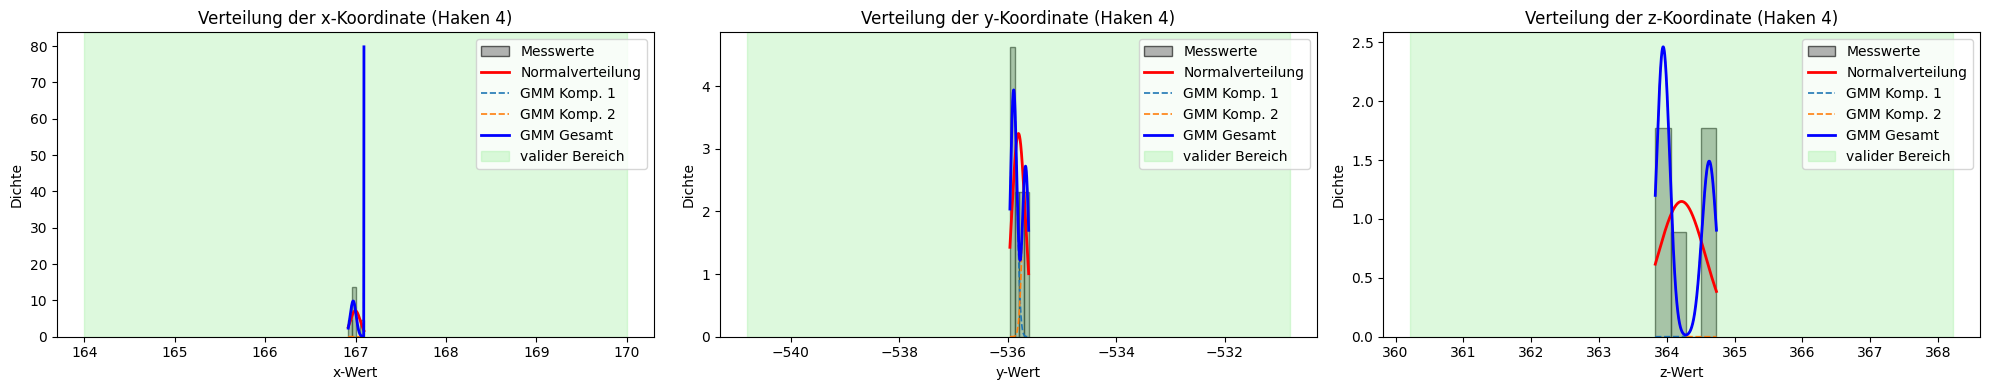

x-Achse: μ-Komponenten = [166.97 167.09], σ-Komponenten = [0.03 0.  ], Gewichte = [0.8 0.2]
Zielbereich (angepasst): [164.00, 170.00] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-535.89 -535.67], σ-Komponenten = [0.06 0.06], Gewichte = [0.6 0.4]
Zielbereich (angepasst): [-540.80, -530.80] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [364.62 363.95], σ-Komponenten = [0.11 0.1 ], Gewichte = [0.4 0.6]
Zielbereich (angepasst): [360.22, 368.22] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  5


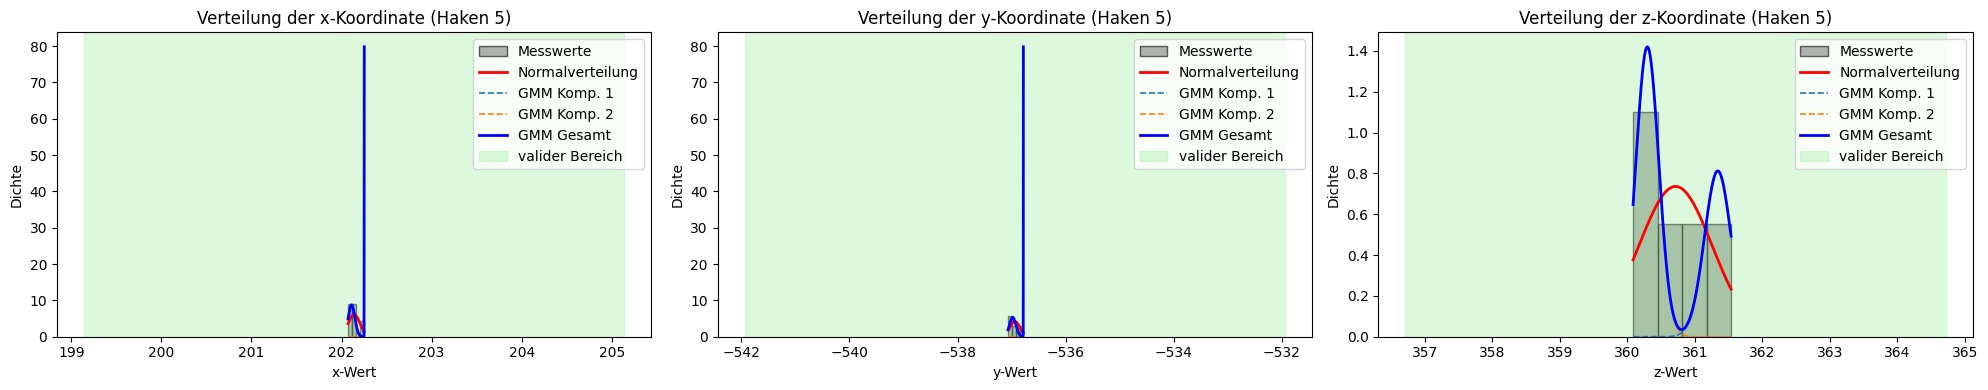

x-Achse: μ-Komponenten = [202.11 202.25], σ-Komponenten = [0.04 0.  ], Gewichte = [0.8 0.2]
Zielbereich (angepasst): [199.14, 205.14] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-536.98 -536.78], σ-Komponenten = [0.06 0.  ], Gewichte = [0.8 0.2]
Zielbereich (angepasst): [-541.94, -531.94] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [361.34 360.3 ], σ-Komponenten = [0.2  0.17], Gewichte = [0.4 0.6]
Zielbereich (angepasst): [356.71, 364.71] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  6


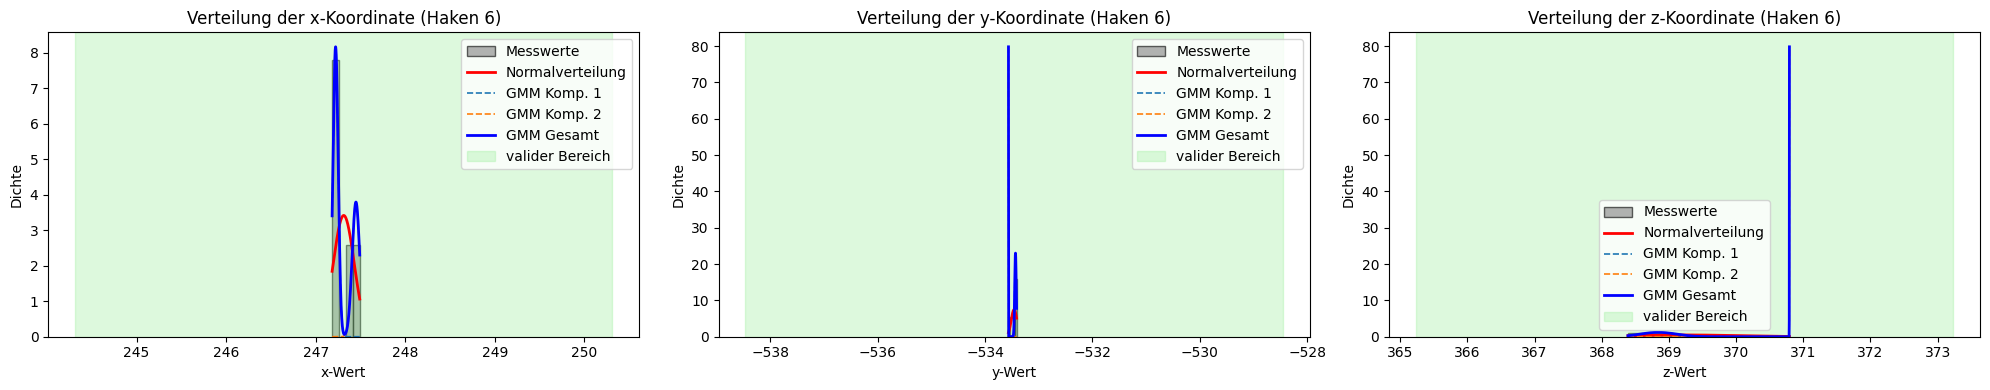

x-Achse: μ-Komponenten = [247.22 247.45], σ-Komponenten = [0.03 0.04], Gewichte = [0.6 0.4]
Zielbereich (angepasst): [244.31, 250.31] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-533.43 -533.56], σ-Komponenten = [0.01 0.  ], Gewichte = [0.8 0.2]
Zielbereich (angepasst): [-538.46, -528.46] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [368.84 370.79], σ-Komponenten = [0.26 0.  ], Gewichte = [0.8 0.2]
Zielbereich (angepasst): [365.23, 373.23] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  7


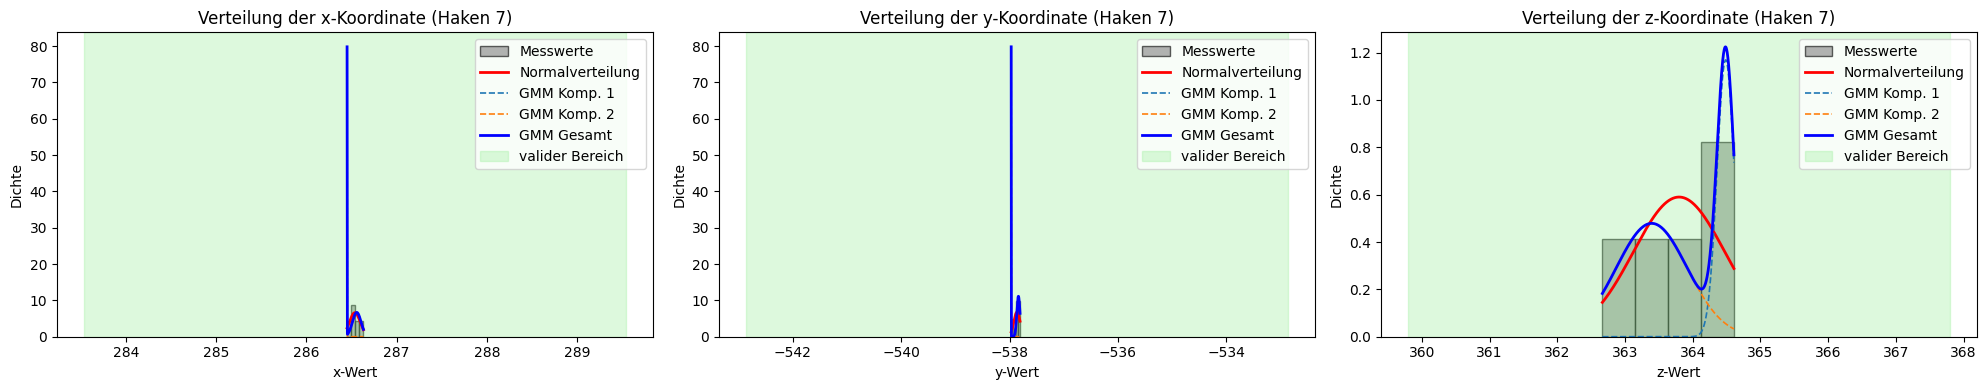

x-Achse: μ-Komponenten = [286.56 286.45], σ-Komponenten = [0.05 0.  ], Gewichte = [0.8 0.2]
Zielbereich (angepasst): [283.54, 289.54] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-537.84 -537.97], σ-Komponenten = [0.03 0.  ], Gewichte = [0.8 0.2]
Zielbereich (angepasst): [-542.86, -532.86] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [364.49 363.39], σ-Komponenten = [0.13 0.52], Gewichte = [0.37 0.63]
Zielbereich (angepasst): [359.80, 367.80] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  8


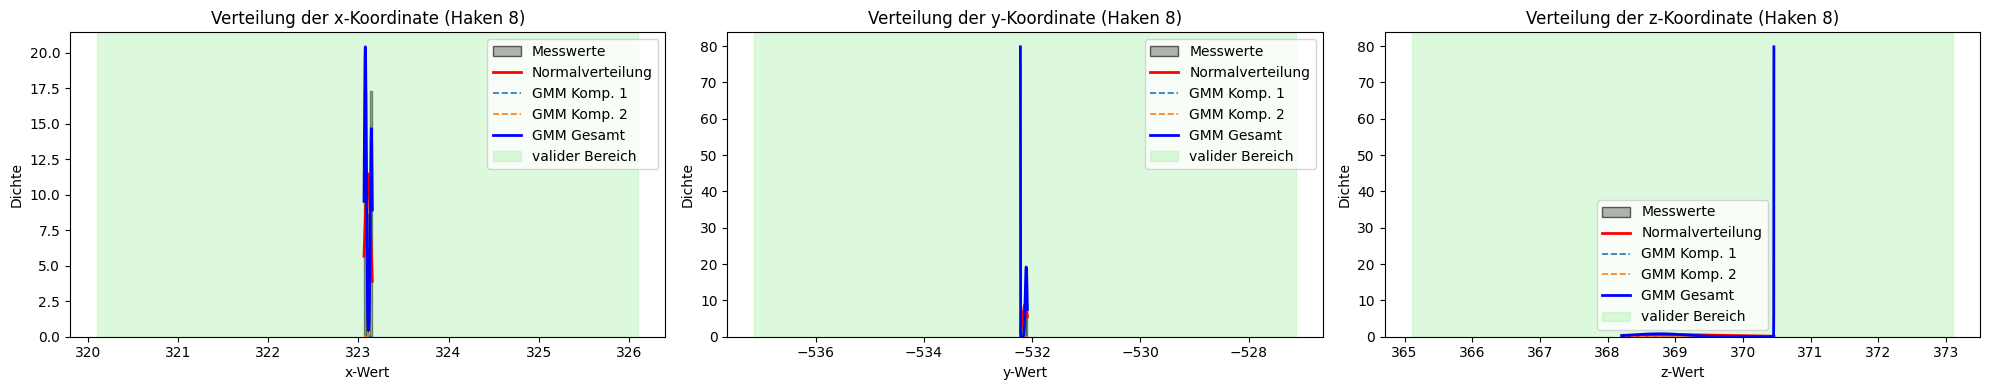

x-Achse: μ-Komponenten = [323.08 323.14], σ-Komponenten = [0.01 0.01], Gewichte = [0.6 0.4]
Zielbereich (angepasst): [320.10, 326.10] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-532.11 -532.21], σ-Komponenten = [0.02 0.  ], Gewichte = [0.8 0.2]
Zielbereich (angepasst): [-537.13, -527.13] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [368.77 370.46], σ-Komponenten = [0.4 0. ], Gewichte = [0.8 0.2]
Zielbereich (angepasst): [365.10, 373.10] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  9


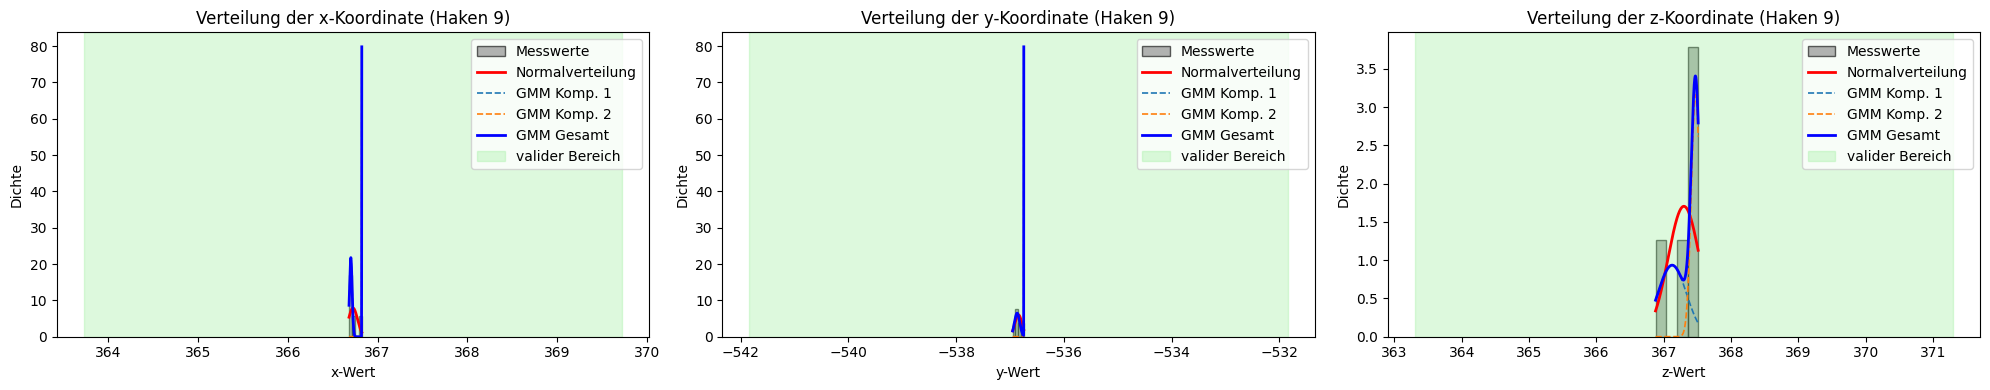

x-Achse: μ-Komponenten = [366.7  366.82], σ-Komponenten = [0.01 0.  ], Gewichte = [0.8 0.2]
Zielbereich (angepasst): [363.73, 369.73] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-536.87 -536.74], σ-Komponenten = [0.05 0.  ], Gewichte = [0.8 0.2]
Zielbereich (angepasst): [-541.84, -531.84] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [367.13 367.47], σ-Komponenten = [0.21 0.06], Gewichte = [0.5 0.5]
Zielbereich (angepasst): [363.30, 371.30] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  10


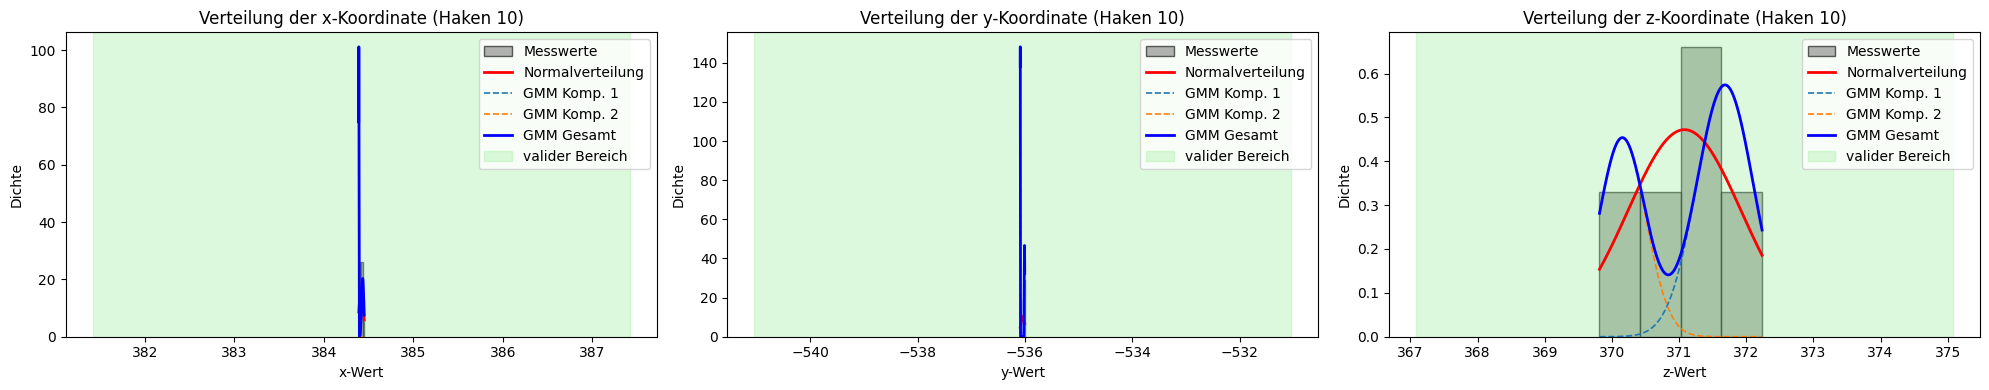

x-Achse: μ-Komponenten = [384.43 384.39], σ-Komponenten = [0.01 0.  ], Gewichte = [0.6 0.4]
Zielbereich (angepasst): [381.42, 387.42] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-536.09 -536.01], σ-Komponenten = [0.   0.01], Gewichte = [0.4 0.6]
Zielbereich (angepasst): [-541.04, -531.04] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [371.68 370.15], σ-Komponenten = [0.42 0.35], Gewichte = [0.61 0.39]
Zielbereich (angepasst): [367.08, 375.08] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  11


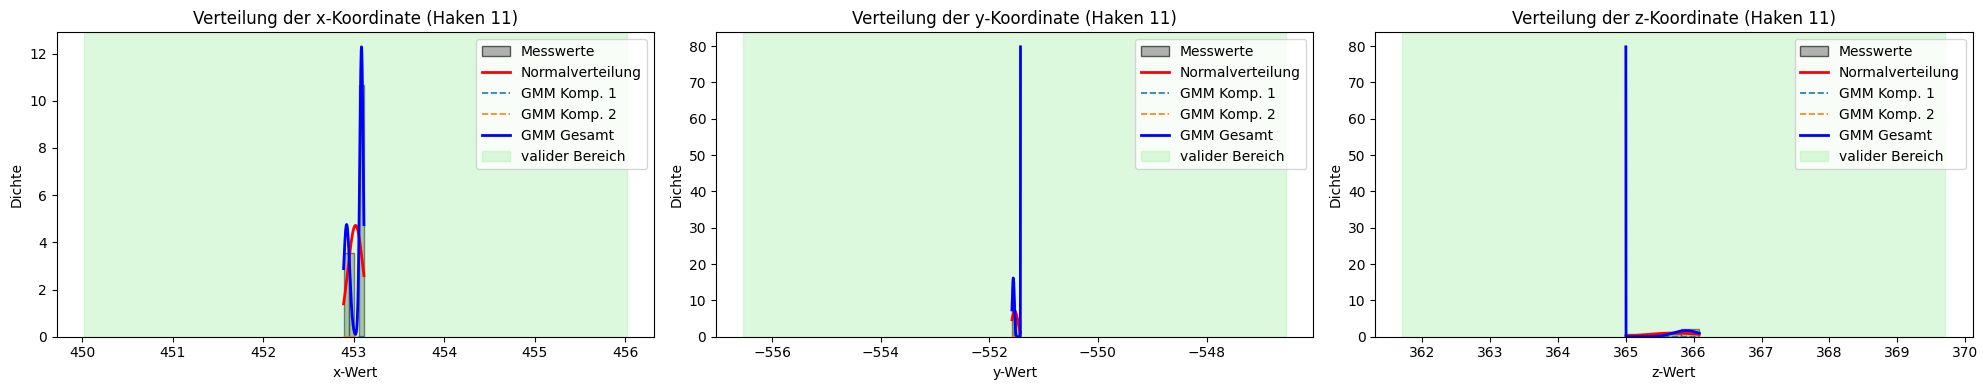

x-Achse: μ-Komponenten = [452.92 453.08], σ-Komponenten = [0.03 0.02], Gewichte = [0.4 0.6]
Zielbereich (angepasst): [450.02, 456.02] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-551.56 -551.43], σ-Komponenten = [0.02 0.  ], Gewichte = [0.8 0.2]
Zielbereich (angepasst): [-556.53, -546.53] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [365.   365.89], σ-Komponenten = [0.   0.19], Gewichte = [0.2 0.8]
Zielbereich (angepasst): [361.71, 369.71] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  12


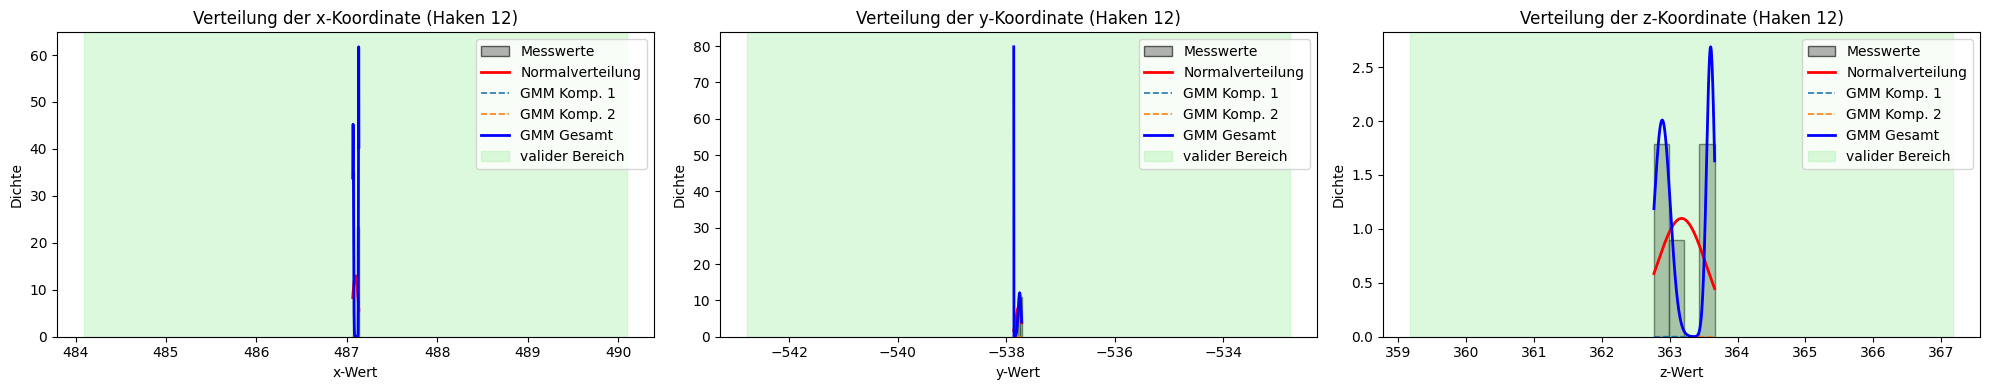

x-Achse: μ-Komponenten = [487.07 487.13], σ-Komponenten = [0.01 0.  ], Gewichte = [0.6 0.4]
Zielbereich (angepasst): [484.09, 490.09] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-537.75 -537.86], σ-Komponenten = [0.03 0.  ], Gewichte = [0.8 0.2]
Zielbereich (angepasst): [-542.77, -532.77] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [363.6  362.89], σ-Komponenten = [0.06 0.12], Gewichte = [0.4 0.6]
Zielbereich (angepasst): [359.17, 367.17] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  13


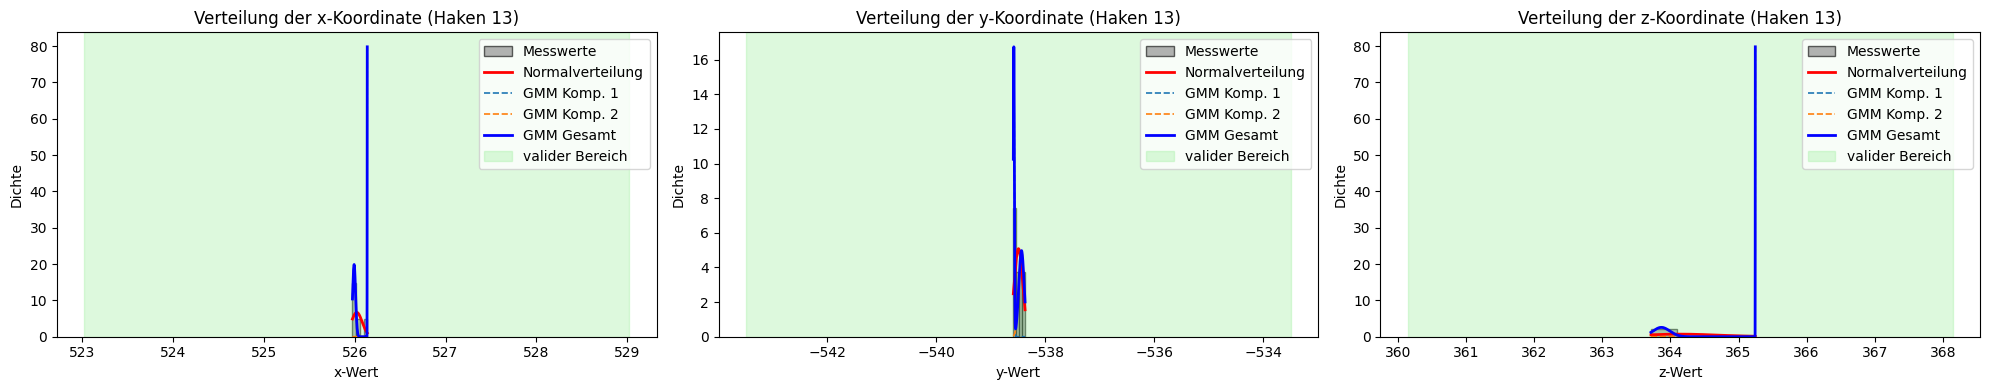

x-Achse: μ-Komponenten = [525.99 526.14], σ-Komponenten = [0.02 0.  ], Gewichte = [0.8 0.2]
Zielbereich (angepasst): [523.02, 529.02] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-538.58 -538.44], σ-Komponenten = [0.01 0.05], Gewichte = [0.4 0.6]
Zielbereich (angepasst): [-543.49, -533.49] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [363.87 365.25], σ-Komponenten = [0.12 0.  ], Gewichte = [0.8 0.2]
Zielbereich (angepasst): [360.14, 368.14] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  14


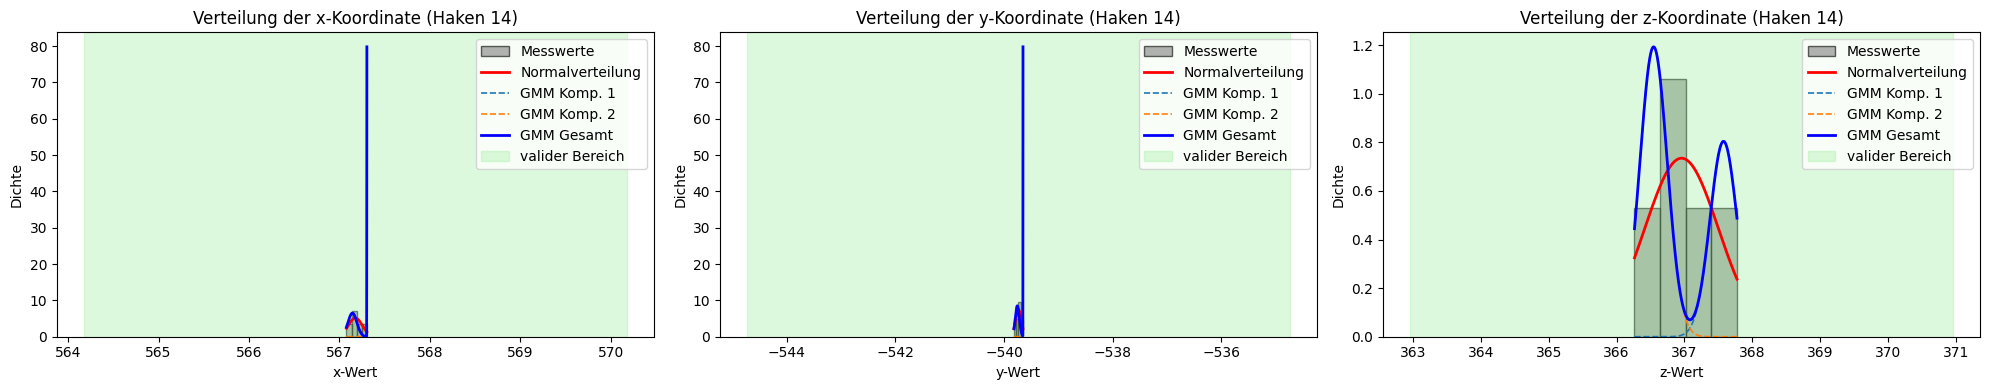

x-Achse: μ-Komponenten = [567.14 567.3 ], σ-Komponenten = [0.05 0.  ], Gewichte = [0.8 0.2]
Zielbereich (angepasst): [564.18, 570.18] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-539.75 -539.65], σ-Komponenten = [0.04 0.  ], Gewichte = [0.8 0.2]
Zielbereich (angepasst): [-544.73, -534.73] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [367.58 366.55], σ-Komponenten = [0.2 0.2], Gewichte = [0.4 0.6]
Zielbereich (angepasst): [362.96, 370.96] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  15


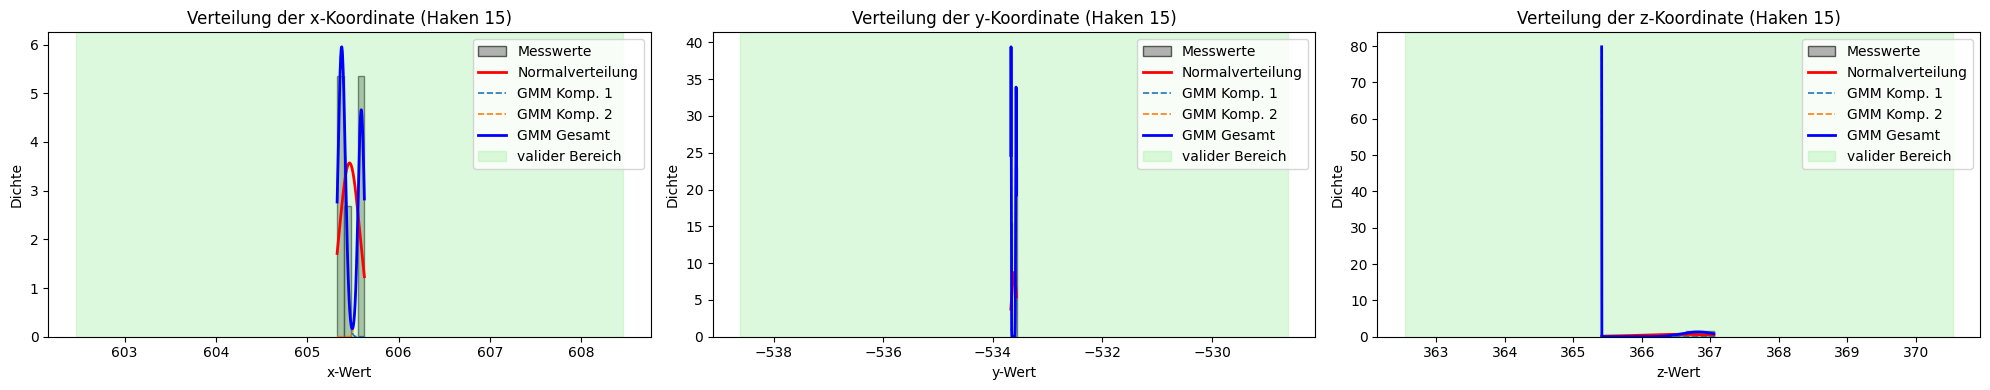

x-Achse: μ-Komponenten = [605.38 605.59], σ-Komponenten = [0.04 0.03], Gewichte = [0.6 0.4]
Zielbereich (angepasst): [602.46, 608.46] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-533.67 -533.58], σ-Komponenten = [0.   0.01], Gewichte = [0.4 0.6]
Zielbereich (angepasst): [-538.61, -528.61] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [365.41 366.82], σ-Komponenten = [0.   0.24], Gewichte = [0.2 0.8]
Zielbereich (angepasst): [362.54, 370.54] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  16


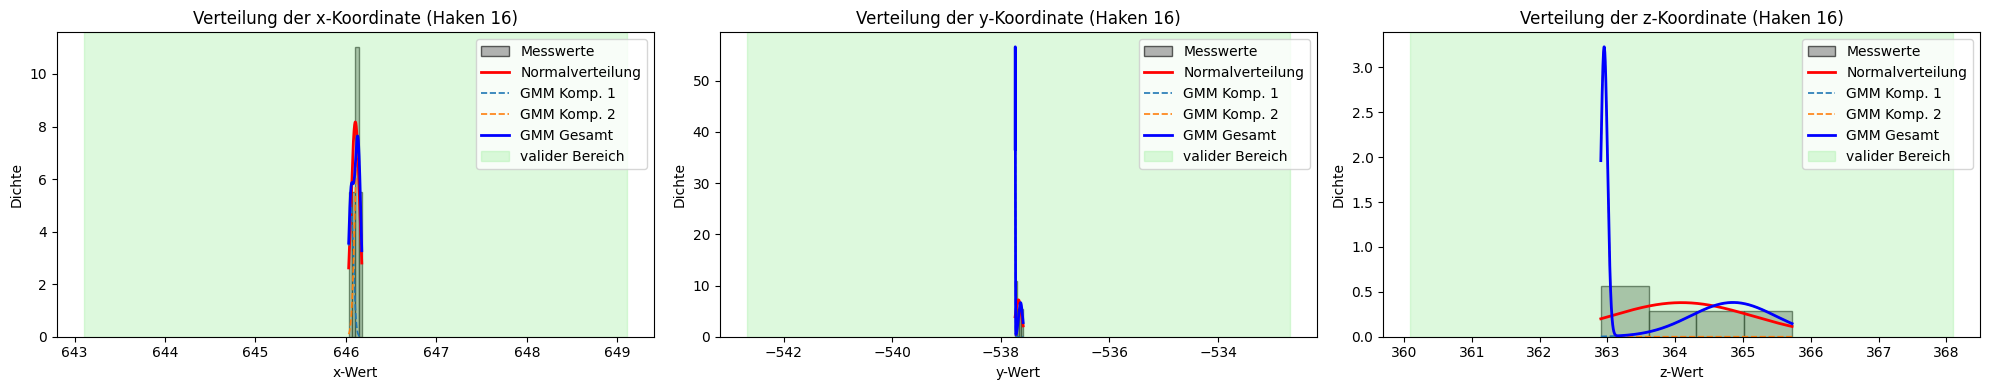

x-Achse: μ-Komponenten = [646.05 646.13], σ-Komponenten = [0.03 0.03], Gewichte = [0.36 0.64]
Zielbereich (angepasst): [643.10, 649.10] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-537.74 -537.64], σ-Komponenten = [0.   0.04], Gewichte = [0.4 0.6]
Zielbereich (angepasst): [-542.68, -532.68] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [364.85 362.95], σ-Komponenten = [0.63 0.05], Gewichte = [0.6 0.4]
Zielbereich (angepasst): [360.09, 368.09] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  17


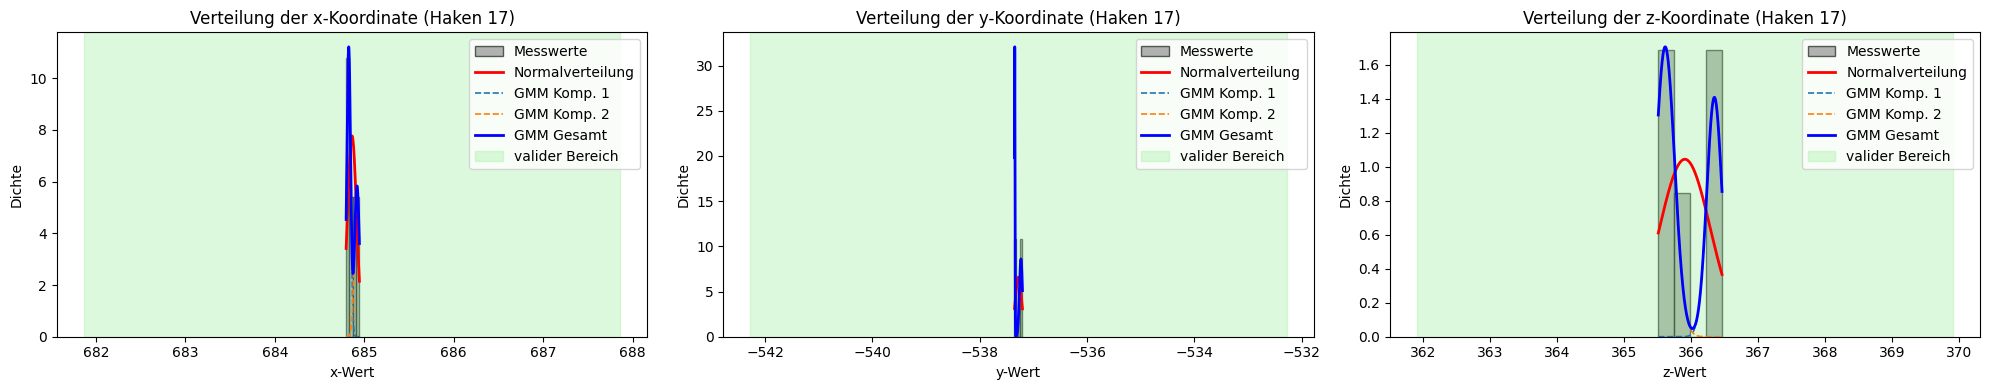

x-Achse: μ-Komponenten = [684.83 684.92], σ-Komponenten = [0.02 0.03], Gewichte = [0.6 0.4]
Zielbereich (angepasst): [681.86, 687.86] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-537.35 -537.23], σ-Komponenten = [0.   0.03], Gewichte = [0.4 0.6]
Zielbereich (angepasst): [-542.28, -532.28] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [366.35 365.61], σ-Komponenten = [0.11 0.14], Gewichte = [0.4 0.6]
Zielbereich (angepasst): [361.91, 369.91] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  18


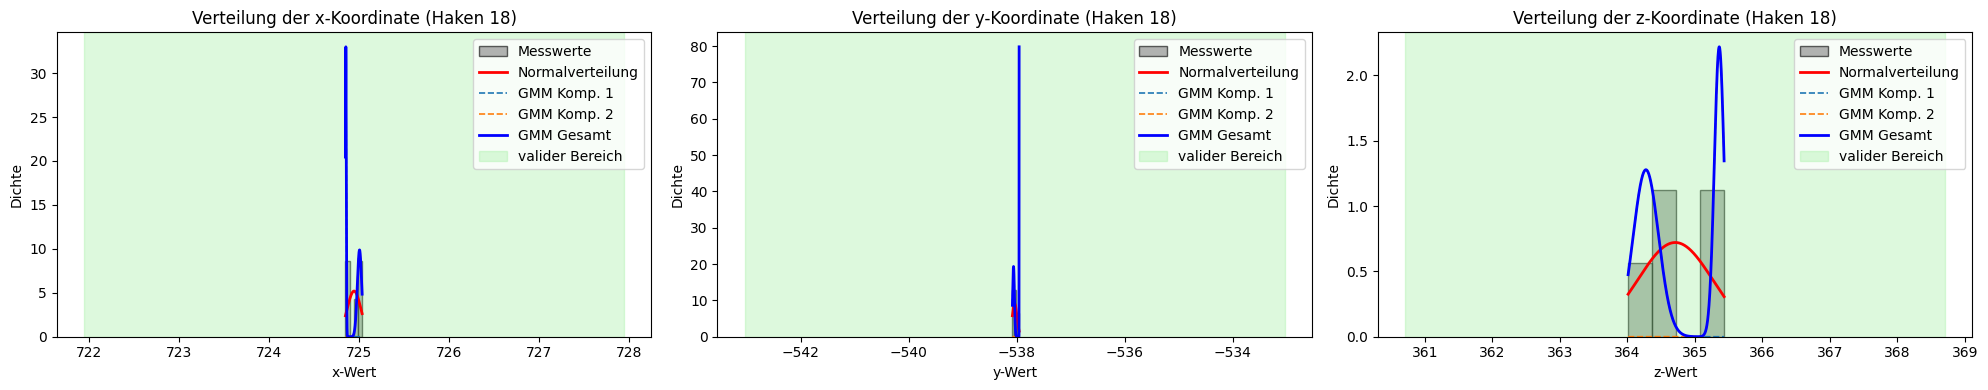

x-Achse: μ-Komponenten = [724.85 725.  ], σ-Komponenten = [0.   0.02], Gewichte = [0.4 0.6]
Zielbereich (angepasst): [721.94, 727.94] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-538.06 -537.95], σ-Komponenten = [0.02 0.  ], Gewichte = [0.8 0.2]
Zielbereich (angepasst): [-543.04, -533.04] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [364.27 365.36], σ-Komponenten = [0.19 0.07], Gewichte = [0.6 0.4]
Zielbereich (angepasst): [360.71, 368.71] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  19


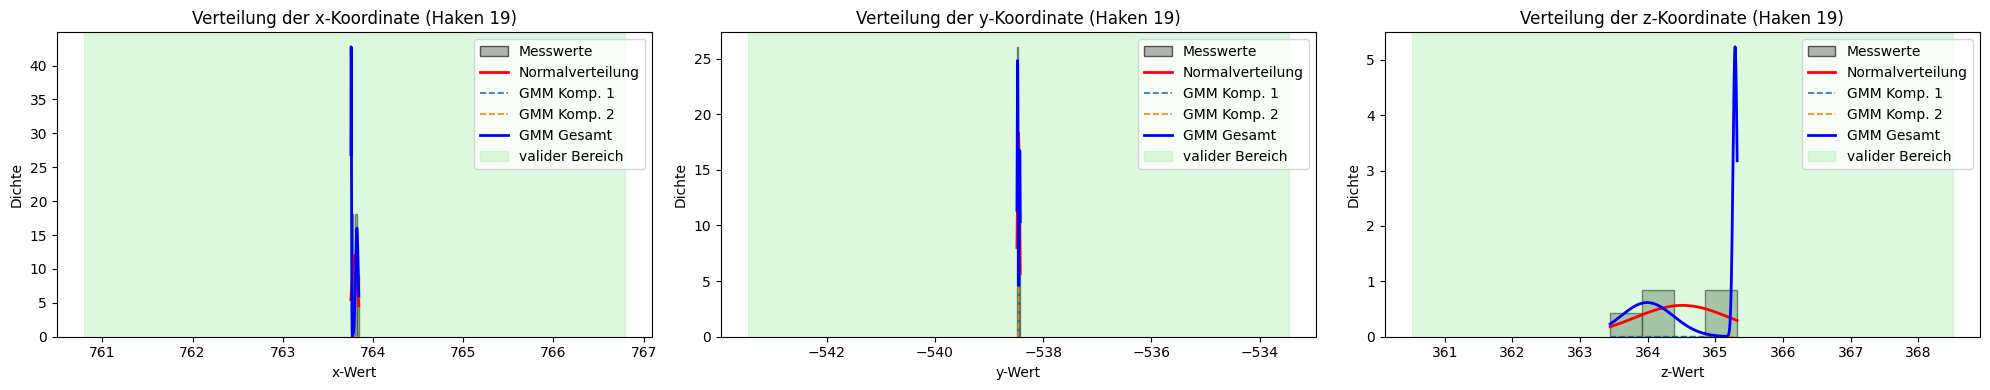

x-Achse: μ-Komponenten = [763.82 763.76], σ-Komponenten = [0.01 0.  ], Gewichte = [0.6 0.4]
Zielbereich (angepasst): [760.80, 766.80] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-538.47 -538.43], σ-Komponenten = [0.01 0.01], Gewichte = [0.6 0.4]
Zielbereich (angepasst): [-543.46, -533.46] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [365.29 363.99], σ-Komponenten = [0.03 0.39], Gewichte = [0.4 0.6]
Zielbereich (angepasst): [360.51, 368.51] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  20


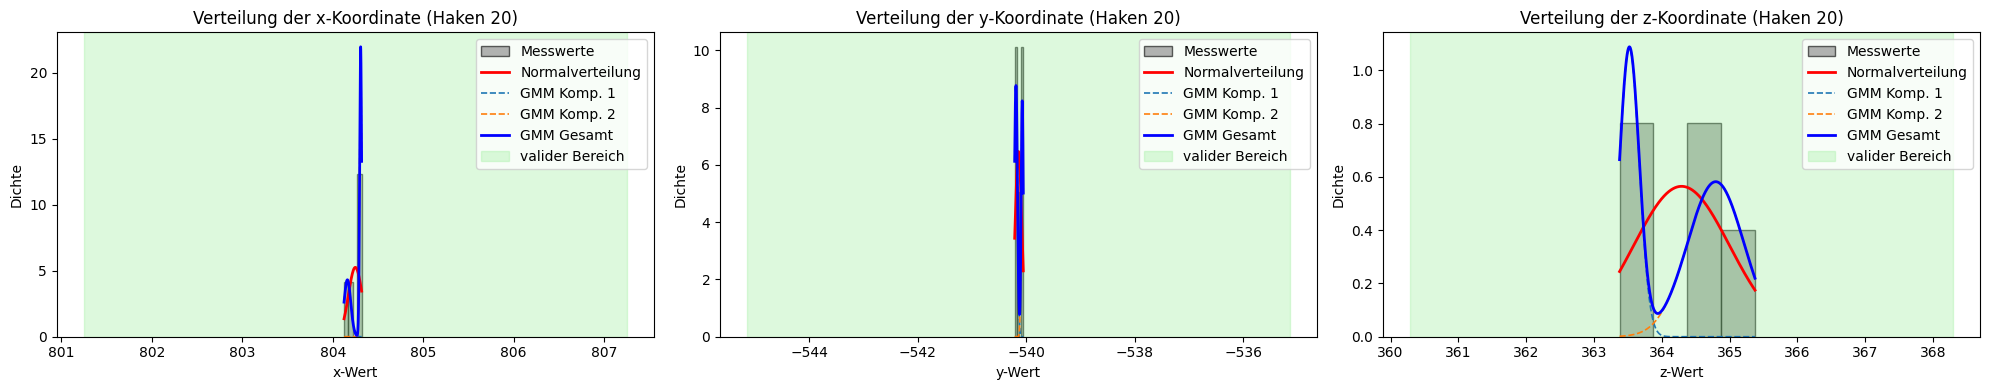

x-Achse: μ-Komponenten = [804.16 804.31], σ-Komponenten = [0.04 0.01], Gewichte = [0.4 0.6]
Zielbereich (angepasst): [801.25, 807.25] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-540.19 -540.08], σ-Komponenten = [0.03 0.02], Gewichte = [0.6 0.4]
Zielbereich (angepasst): [-545.15, -535.15] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [363.52 364.79], σ-Komponenten = [0.15 0.41], Gewichte = [0.4 0.6]
Zielbereich (angepasst): [360.29, 368.29] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  21


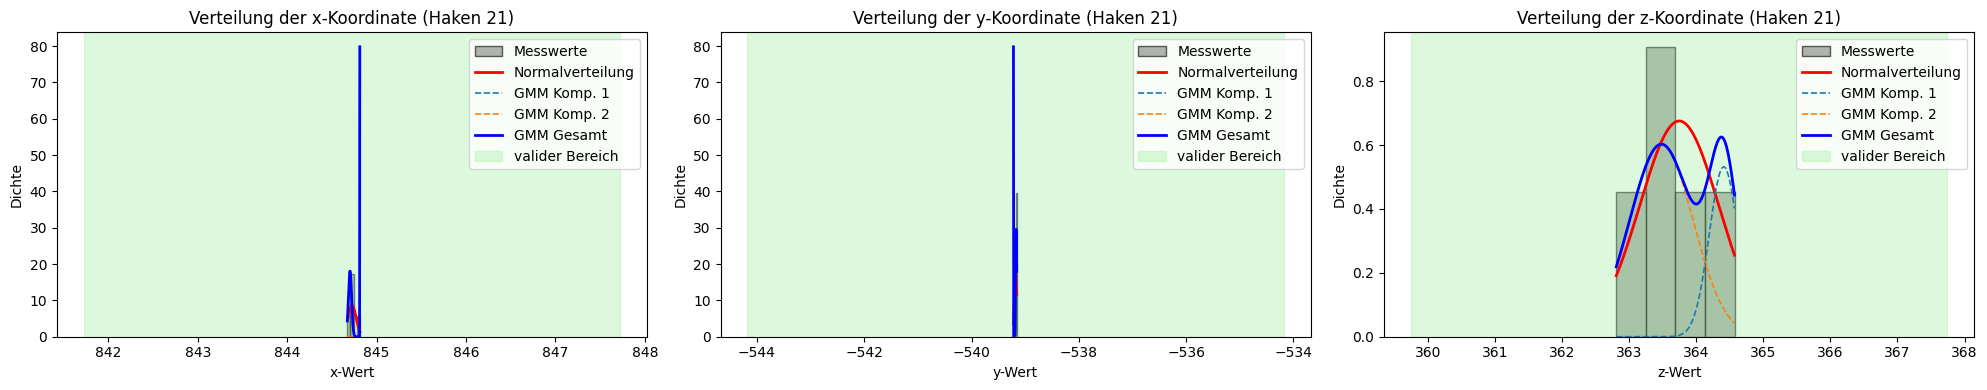

x-Achse: μ-Komponenten = [844.7  844.81], σ-Komponenten = [0.02 0.  ], Gewichte = [0.8 0.2]
Zielbereich (angepasst): [841.72, 847.72] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-539.17 -539.22], σ-Komponenten = [0.01 0.  ], Gewichte = [0.8 0.2]
Zielbereich (angepasst): [-544.18, -534.18] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [364.41 363.48], σ-Komponenten = [0.21 0.47], Gewichte = [0.29 0.71]
Zielbereich (angepasst): [359.75, 367.75] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  22


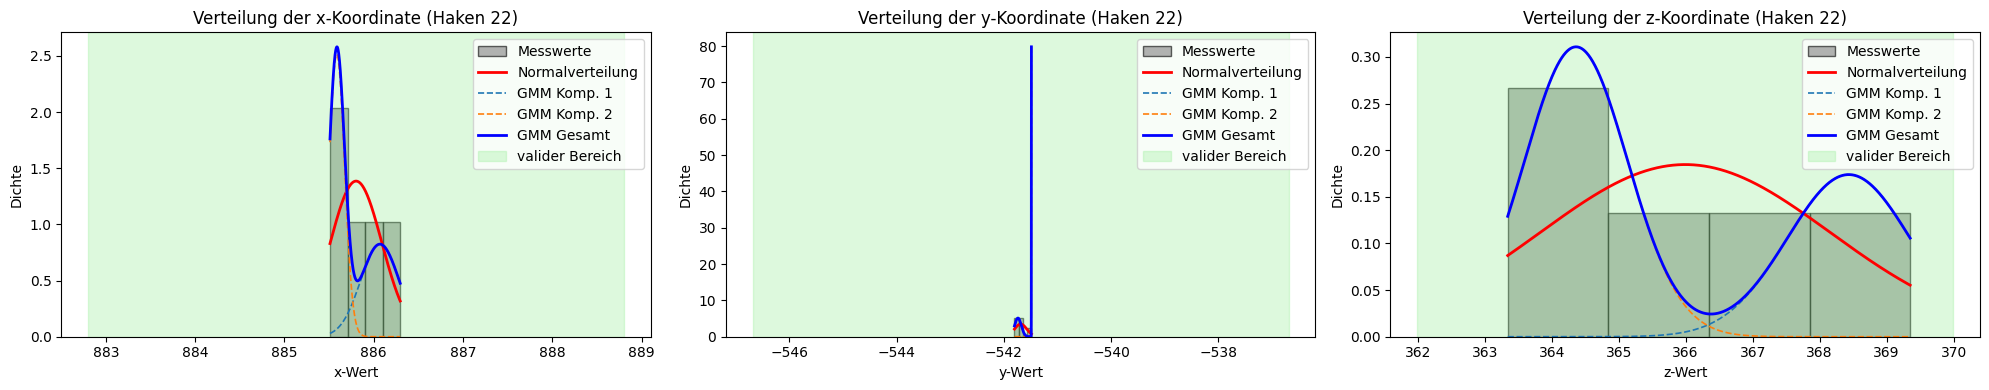

x-Achse: μ-Komponenten = [886.07 885.59], σ-Komponenten = [0.22 0.09], Gewichte = [0.45 0.55]
Zielbereich (angepasst): [882.80, 888.80] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-541.74 -541.49], σ-Komponenten = [0.06 0.  ], Gewichte = [0.8 0.2]
Zielbereich (angepasst): [-546.69, -536.69] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [368.43 364.36], σ-Komponenten = [0.92 0.77], Gewichte = [0.4 0.6]
Zielbereich (angepasst): [361.99, 369.99] → Wahrscheinlichkeit = 98.14 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 98.14 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  23


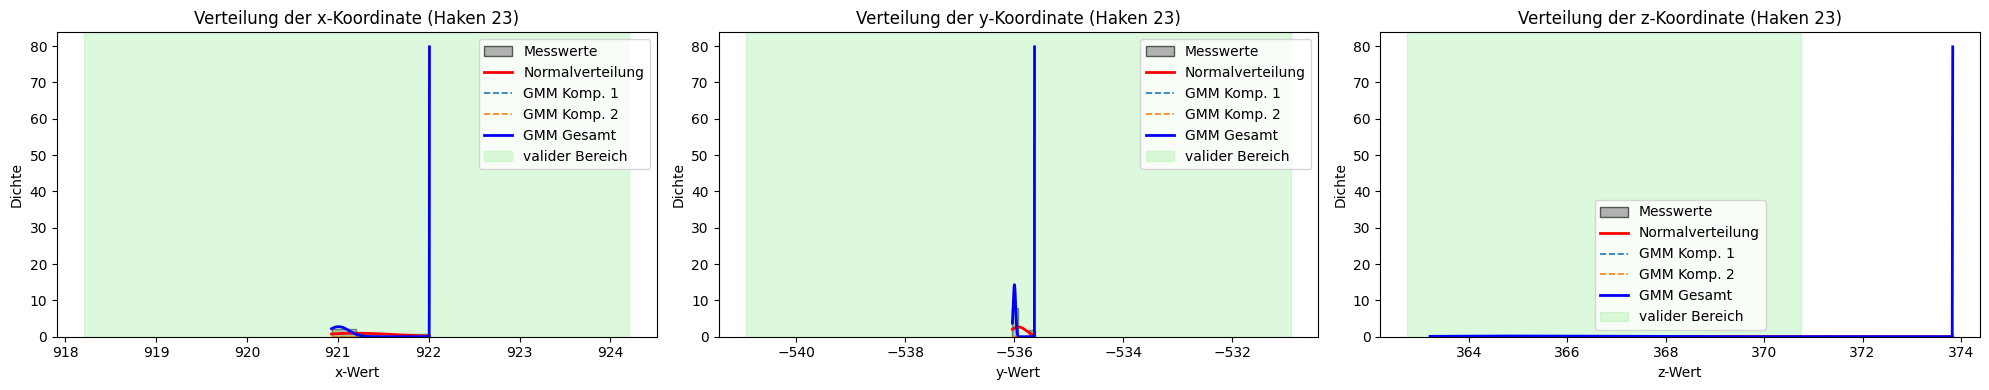

x-Achse: μ-Komponenten = [921.01 922.01], σ-Komponenten = [0.12 0.  ], Gewichte = [0.8 0.2]
Zielbereich (angepasst): [918.21, 924.21] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-535.99 -535.63], σ-Komponenten = [0.02 0.  ], Gewichte = [0.8 0.2]
Zielbereich (angepasst): [-540.92, -530.92] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [364.98 373.83], σ-Komponenten = [1.62 0.  ], Gewichte = [0.8 0.2]
Zielbereich (angepasst): [362.75, 370.75] → Wahrscheinlichkeit = 73.20 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 73.20 %

Durchschnittliche Verteilungs-Mittelwerte - XYZ:  485.58890456461876 -538.0341992381191 365.23393820934325
Durchschnittliche Standardabweichungen - XYZ:  0.0869799286525067 0.06732912489648797 0.8026741921170348


In [17]:
mu_x_mean = 0
mu_y_mean = 0
mu_z_mean = 0

std_x_mean = 0
std_y_mean = 0
std_z_mean = 0

for hook_num in range(len(dicts_list[0])):
    mu_std_results, probs = plot_prob_and_hist(hook_num+1, dicts_list)
    
    mu_x_mean += mu_std_results['x'][0]
    mu_y_mean += mu_std_results['y'][0]
    mu_z_mean += mu_std_results['z'][0]
    
    std_x_mean += mu_std_results['x'][1]
    std_y_mean += mu_std_results['y'][1]
    std_z_mean += mu_std_results['z'][1]

mu_x_mean /= len(dicts_list[0])
mu_y_mean /= len(dicts_list[0])
mu_z_mean /= len(dicts_list[0])

std_x_mean /= len(dicts_list[0])
std_y_mean /= len(dicts_list[0])
std_z_mean /= len(dicts_list[0])

print("Durchschnittliche Verteilungs-Mittelwerte - XYZ: ", mu_x_mean, mu_y_mean, mu_z_mean)
print("Durchschnittliche Standardabweichungen - XYZ: ", std_x_mean, std_y_mean, std_z_mean)

***
## **Triangulationsmethoden**

In [19]:
horizontal_0_filepath = '/home/mo/Thesis/Evaluation/1_Scan-Prozess/1_Triangulationsmethoden/1_Horizontale-Triangulation/0/global_hook_dict_horizontal.csv'
horizontal_far_filepath = '/home/mo/Thesis/Evaluation/1_Scan-Prozess/1_Triangulationsmethoden/1_Horizontale-Triangulation/-20/global_hook_dict_horizontal.csv'
horizontal_near_filepath = '/home/mo/Thesis/Evaluation/1_Scan-Prozess/1_Triangulationsmethoden/1_Horizontale-Triangulation/20/global_hook_dict_horizontal.csv'

vertical_0_filepath = '/home/mo/Thesis/Evaluation/1_Scan-Prozess/1_Triangulationsmethoden/2_Vertikale-Triangulation/0/global_hook_dict_vertical.csv'
vertical_far_filepath = '/home/mo/Thesis/Evaluation/1_Scan-Prozess/1_Triangulationsmethoden/2_Vertikale-Triangulation/-20/global_hook_dict_vertical.csv'
vertical_near_filepath = '/home/mo/Thesis/Evaluation/1_Scan-Prozess/1_Triangulationsmethoden/2_Vertikale-Triangulation/20/global_hook_dict_vertical.csv'

In [20]:
horizontal_0_dict = load_csv_to_dict(horizontal_0_filepath)
horizontal_far_dict = load_csv_to_dict(horizontal_far_filepath)
horizontal_near_dict = load_csv_to_dict(horizontal_near_filepath)

vertical_0_dict = load_csv_to_dict(vertical_0_filepath)
vertical_far_dict = load_csv_to_dict(vertical_far_filepath)
vertical_near_dict = load_csv_to_dict(vertical_near_filepath)

print("Dicts in Ordnung!") if len(horizontal_0_dict) == len(horizontal_far_dict) == len(horizontal_near_dict) == len(vertical_0_dict) == len(vertical_far_dict) == len(vertical_near_dict) else print("Ungleiche Längen!")

Dicts in Ordnung!


In [21]:
def extract_xyz_vals(horizontal_dicts_list, vertical_dicts_list):
    """
    - Extrahiert für jeden Haken die XYZ-Werte für Tip und Lowpoint - für beide Triangulationsmethoden
    - Berechnet die kombinierte Triangulation als Mittelwert beider Ergebnisse
    """
    horizontal_vals = {
        'x_tip_vals': [],
        'y_tip_vals': [],
        'z_tip_vals': [],
        'x_lowpoint_vals': [],
        'y_lowpoint_vals': [],
        'z_lowpoint_vals': []
        }
    vertical_vals = {
        'x_tip_vals': [],
        'y_tip_vals': [],
        'z_tip_vals': [],
        'x_lowpoint_vals': [],
        'y_lowpoint_vals': [],
        'z_lowpoint_vals': []
        }
    combined_vals = {
        'x_tip_vals': [],
        'y_tip_vals': [],
        'z_tip_vals': [],
        'x_lowpoint_vals': [],
        'y_lowpoint_vals': [],
        'z_lowpoint_vals': []
        }

    for hook_idx in range(len(horizontal_dicts_list[0])-2):
        hook_key = str(hook_idx + 1)
        for dict_idx in range(len(horizontal_dicts_list)):
            dict = horizontal_dicts_list[dict_idx]
            xyz_tip_in_camframe = dict[hook_key]['xyz_tip_in_camframe']
            xyz_lowpoint_in_camframe = dict[hook_key]['xyz_lowpoint_in_camframe']
            horizontal_vals['x_tip_vals'].append(xyz_tip_in_camframe[0])
            horizontal_vals['y_tip_vals'].append(xyz_tip_in_camframe[1])
            horizontal_vals['z_tip_vals'].append(xyz_tip_in_camframe[2])
            horizontal_vals['x_lowpoint_vals'].append(xyz_lowpoint_in_camframe[0])
            horizontal_vals['y_lowpoint_vals'].append(xyz_lowpoint_in_camframe[1])
            horizontal_vals['z_lowpoint_vals'].append(xyz_lowpoint_in_camframe[2])
            
        for dict_idx in range(len(vertical_dicts_list)):
            dict = vertical_dicts_list[dict_idx]
            xyz_tip_in_camframe = dict[hook_key]['xyz_tip_in_camframe']
            xyz_lowpoint_in_camframe = dict[hook_key]['xyz_lowpoint_in_camframe']
            vertical_vals['x_tip_vals'].append(xyz_tip_in_camframe[0])
            vertical_vals['y_tip_vals'].append(xyz_tip_in_camframe[1])
            vertical_vals['z_tip_vals'].append(xyz_tip_in_camframe[2])
            vertical_vals['x_lowpoint_vals'].append(xyz_lowpoint_in_camframe[0])
            vertical_vals['y_lowpoint_vals'].append(xyz_lowpoint_in_camframe[1])
            vertical_vals['z_lowpoint_vals'].append(xyz_lowpoint_in_camframe[2])

            combined_vals['x_tip_vals'].append((xyz_tip_in_camframe[0] + horizontal_vals['x_tip_vals'][dict_idx])/2)
            combined_vals['y_tip_vals'].append((xyz_tip_in_camframe[1] + horizontal_vals['y_tip_vals'][dict_idx])/2)
            combined_vals['z_tip_vals'].append((xyz_tip_in_camframe[2] + horizontal_vals['z_tip_vals'][dict_idx])/2)
            combined_vals['x_lowpoint_vals'].append((xyz_tip_in_camframe[0] + horizontal_vals['x_lowpoint_vals'][dict_idx])/2)
            combined_vals['y_lowpoint_vals'].append((xyz_tip_in_camframe[1] + horizontal_vals['y_lowpoint_vals'][dict_idx])/2)
            combined_vals['z_lowpoint_vals'].append((xyz_tip_in_camframe[2] + horizontal_vals['z_lowpoint_vals'][dict_idx])/2)
    return horizontal_vals, vertical_vals, combined_vals

In [22]:
def plot_xyz_values(horizontal_vals_dict, vertical_vals_dict, combined_vals_dict, to_plot='tip'):
    """
    Erstellt einen 3x3 Plot zur Darstellung der XYZ-Koordinaten für Horizontal, Vertikal, Kombiniert
        -> die Koordinaten sind entweder für Spitze (tip) oder Senke (lowpoint) aufgezeichnet -> steht im Plot-Titel
    """
    
    # Farben und zugehörige Labels im rotierenden Muster
    colors = ['black', 'green', 'red']
    labels = ['mittel', 'nah', 'fern']

    # Auswahl der richtigen Keys basierend auf 'to_plot'
    key_suffix = f"_{to_plot}_vals"

    # Dictionaries der drei Kategorien
    all_data = {
        'Horizontal': horizontal_vals_dict,
        'Vertikal': vertical_vals_dict,
        'Kombiniert': combined_vals_dict
    }

    fig, axes = plt.subplots(3, 3, figsize=(20, 12))
    fig.suptitle(f"XYZ-Koordinaten für {to_plot.capitalize()}", fontsize=16)

    # Achsen-Labels
    axes_labels = ['X', 'Y', 'Z']

    for row_idx, (category, data_dict) in enumerate(all_data.items()):
        for col_idx, axis in enumerate(['x', 'y', 'z']):
            ax = axes[row_idx, col_idx]
            vals = data_dict[f'{axis}{key_suffix}']

            # Punkte und Linien nach Kategorie zeichnen
            plotted_labels = set()
            grouped_vals = {label: [] for label in labels}
            grouped_indices = {label: [] for label in labels}

            for i, val in enumerate(vals):
                color = colors[i % len(colors)]
                label = labels[i % len(labels)]
                grouped_vals[label].append(val)
                grouped_indices[label].append(i)

                if label not in plotted_labels:
                    ax.plot(i, val, 'o', color=color, label=label)
                    plotted_labels.add(label)
                else:
                    ax.plot(i, val, 'o', color=color)

            # Linien für jede Gruppe zeichnen
            for label, color in zip(labels, colors):
                if grouped_indices[label]:
                    ax.plot(grouped_indices[label], grouped_vals[label], linestyle='-', color=color, alpha=0.7)

            ax.set_title(f"{category} - {axes_labels[col_idx]}")
            ax.set_xlabel('Haken-Instanz')
            ax.set_ylabel(f'{axes_labels[col_idx]}-Wert')
            ax.grid()
            ax.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

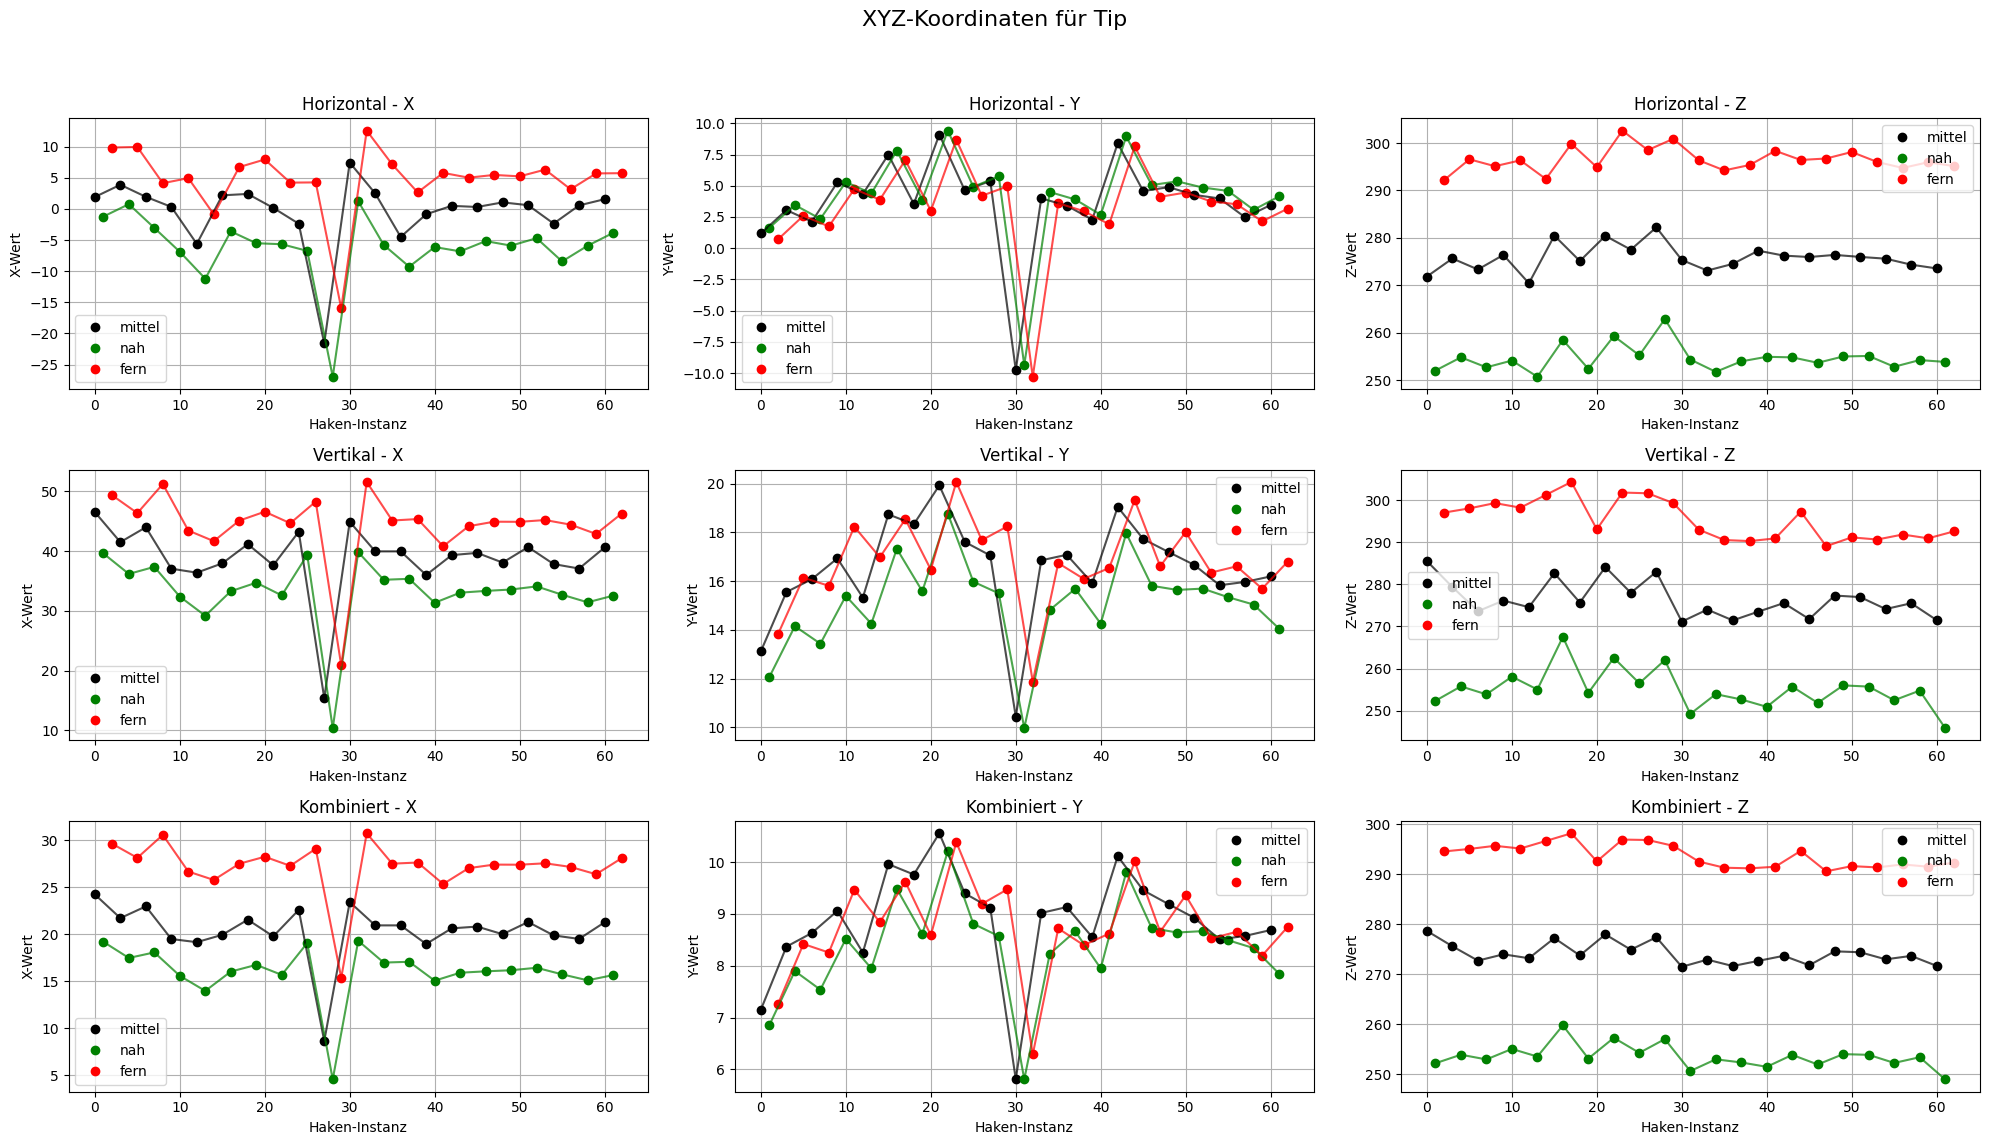

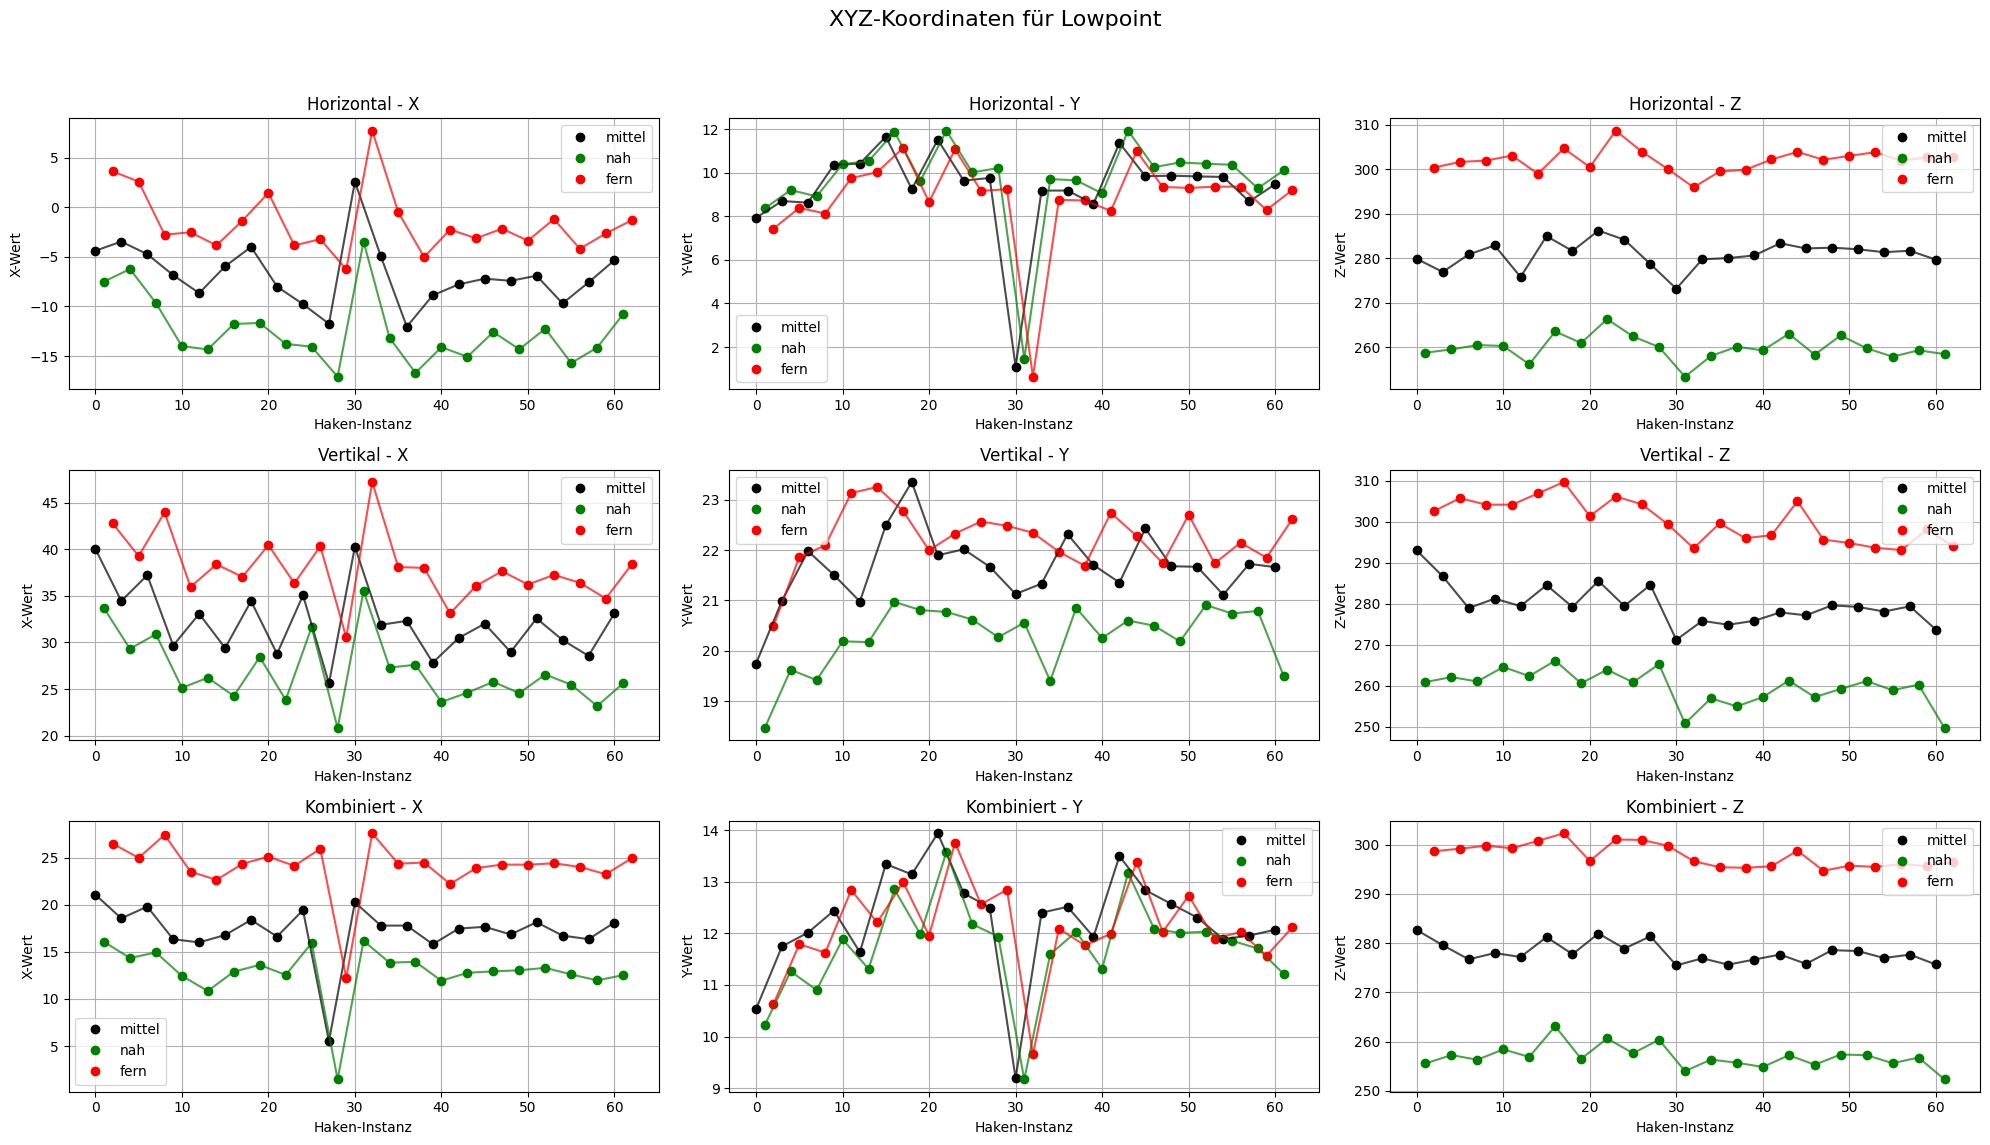

In [23]:
horizontal_dicts_list = [horizontal_0_dict, horizontal_near_dict, horizontal_far_dict]
vertical_dicts_list = [vertical_0_dict, vertical_near_dict, vertical_far_dict]
horizontal_vals, vertical_vals, combined_vals = extract_xyz_vals(horizontal_dicts_list, vertical_dicts_list)
plot_xyz_values(horizontal_vals, vertical_vals, combined_vals, 'tip')
plot_xyz_values(horizontal_vals, vertical_vals, combined_vals, 'lowpoint')

In [24]:
def calculate_differences(vals_dict):
    """
    Berechnet die Differenzen zwischen den drei Messreihen für jedes Verfahren
    """
    mean_far_diffs = {
        'x_tip_vals': [],
        'y_tip_vals': [],
        'z_tip_vals': [],
        'x_lowpoint_vals': [],
        'y_lowpoint_vals': [],
        'z_lowpoint_vals': []
    }
    mean_near_diffs = {
        'x_tip_vals': [],
        'y_tip_vals': [],
        'z_tip_vals': [],
        'x_lowpoint_vals': [],
        'y_lowpoint_vals': [],
        'z_lowpoint_vals': []
    }

    for val_idx in range(0, len(vals_dict['x_tip_vals']) - 2, 3):
        mean_near_diffs['x_tip_vals'].append(vals_dict['x_tip_vals'][val_idx] - vals_dict['x_tip_vals'][val_idx+1])
        mean_far_diffs['x_tip_vals'].append(vals_dict['x_tip_vals'][val_idx] - vals_dict['x_tip_vals'][val_idx+2])
        mean_near_diffs['y_tip_vals'].append(vals_dict['y_tip_vals'][val_idx] - vals_dict['y_tip_vals'][val_idx+1])
        mean_far_diffs['y_tip_vals'].append(vals_dict['y_tip_vals'][val_idx] - vals_dict['y_tip_vals'][val_idx+2])
        mean_near_diffs['z_tip_vals'].append(vals_dict['z_tip_vals'][val_idx] - vals_dict['z_tip_vals'][val_idx+1])
        mean_far_diffs['z_tip_vals'].append(vals_dict['z_tip_vals'][val_idx] - vals_dict['z_tip_vals'][val_idx+2])

        mean_near_diffs['x_lowpoint_vals'].append(vals_dict['x_lowpoint_vals'][val_idx] - vals_dict['x_lowpoint_vals'][val_idx+1])
        mean_far_diffs['x_lowpoint_vals'].append(vals_dict['x_lowpoint_vals'][val_idx] - vals_dict['x_lowpoint_vals'][val_idx+2])
        mean_near_diffs['y_lowpoint_vals'].append(vals_dict['y_lowpoint_vals'][val_idx] - vals_dict['y_lowpoint_vals'][val_idx+1])
        mean_far_diffs['y_lowpoint_vals'].append(vals_dict['y_lowpoint_vals'][val_idx] - vals_dict['y_lowpoint_vals'][val_idx+2])
        mean_near_diffs['z_lowpoint_vals'].append(vals_dict['z_lowpoint_vals'][val_idx] - vals_dict['z_lowpoint_vals'][val_idx+1])
        mean_far_diffs['z_lowpoint_vals'].append(vals_dict['z_lowpoint_vals'][val_idx] - vals_dict['z_lowpoint_vals'][val_idx+2])

    return mean_far_diffs, mean_near_diffs

In [25]:
horizontal_far_diffs, horizontal_near_diffs = calculate_differences(horizontal_vals)
vertical_far_diffs, vertical_near_diffs = calculate_differences(vertical_vals)
combined_far_diffs, combined_near_diffs = calculate_differences(combined_vals)

In [26]:
def plot_diffs(horizontal_far_diffs, horizontal_near_diffs,
               vertical_far_diffs, vertical_near_diffs,
               combined_far_diffs, combined_near_diffs,
               to_plot='tip'):
    """
    Plottet einen 3x3 Plot für die Differenz-Werte
        -> entweder für Spitze (tip) oder Senke (lowpoint)
    """
    
    colors = {'nah': 'green', 'fern': 'red'}
    
    key_suffix = f"_{to_plot}_vals"

    # Struktur der Daten
    all_data = {
        'Horizontale Triangulation': {'nah': horizontal_near_diffs, 'fern': horizontal_far_diffs},
        'Vertikale Triangulation': {'nah': vertical_near_diffs, 'fern': vertical_far_diffs},
        'Kombinierte Triangulation': {'nah': combined_near_diffs, 'fern': combined_far_diffs},
    }

    fig, axes = plt.subplots(3, 3, figsize=(20, 12))
    fig.suptitle(f"Differenzen für {to_plot.capitalize()}", fontsize=16)

    axes_labels = ['X', 'Y', 'Z']

    for row_idx, (category, sources) in enumerate(all_data.items()):
        for col_idx, axis in enumerate(['x', 'y', 'z']):
            ax = axes[row_idx, col_idx]
            for label, data_dict in sources.items():
                vals = data_dict[f'{axis}{key_suffix}']
                if vals:
                    ax.plot(range(len(vals)), vals, 'o-', color=colors[label], label=label)

            # Zusätzliche Linien für z-Achsen
            if axis == 'z':
                for y in [-20, 0, 20]:
                    ax.axhline(y=y, linestyle='--', color='magenta', linewidth=2, label=f'soll {y}')

            ax.set_title(f"{category} - {axes_labels[col_idx]}")
            ax.set_xlabel('Haken-Instanz')
            ax.set_ylabel(f'Diff {axes_labels[col_idx]}')
            ax.grid()
            ax.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

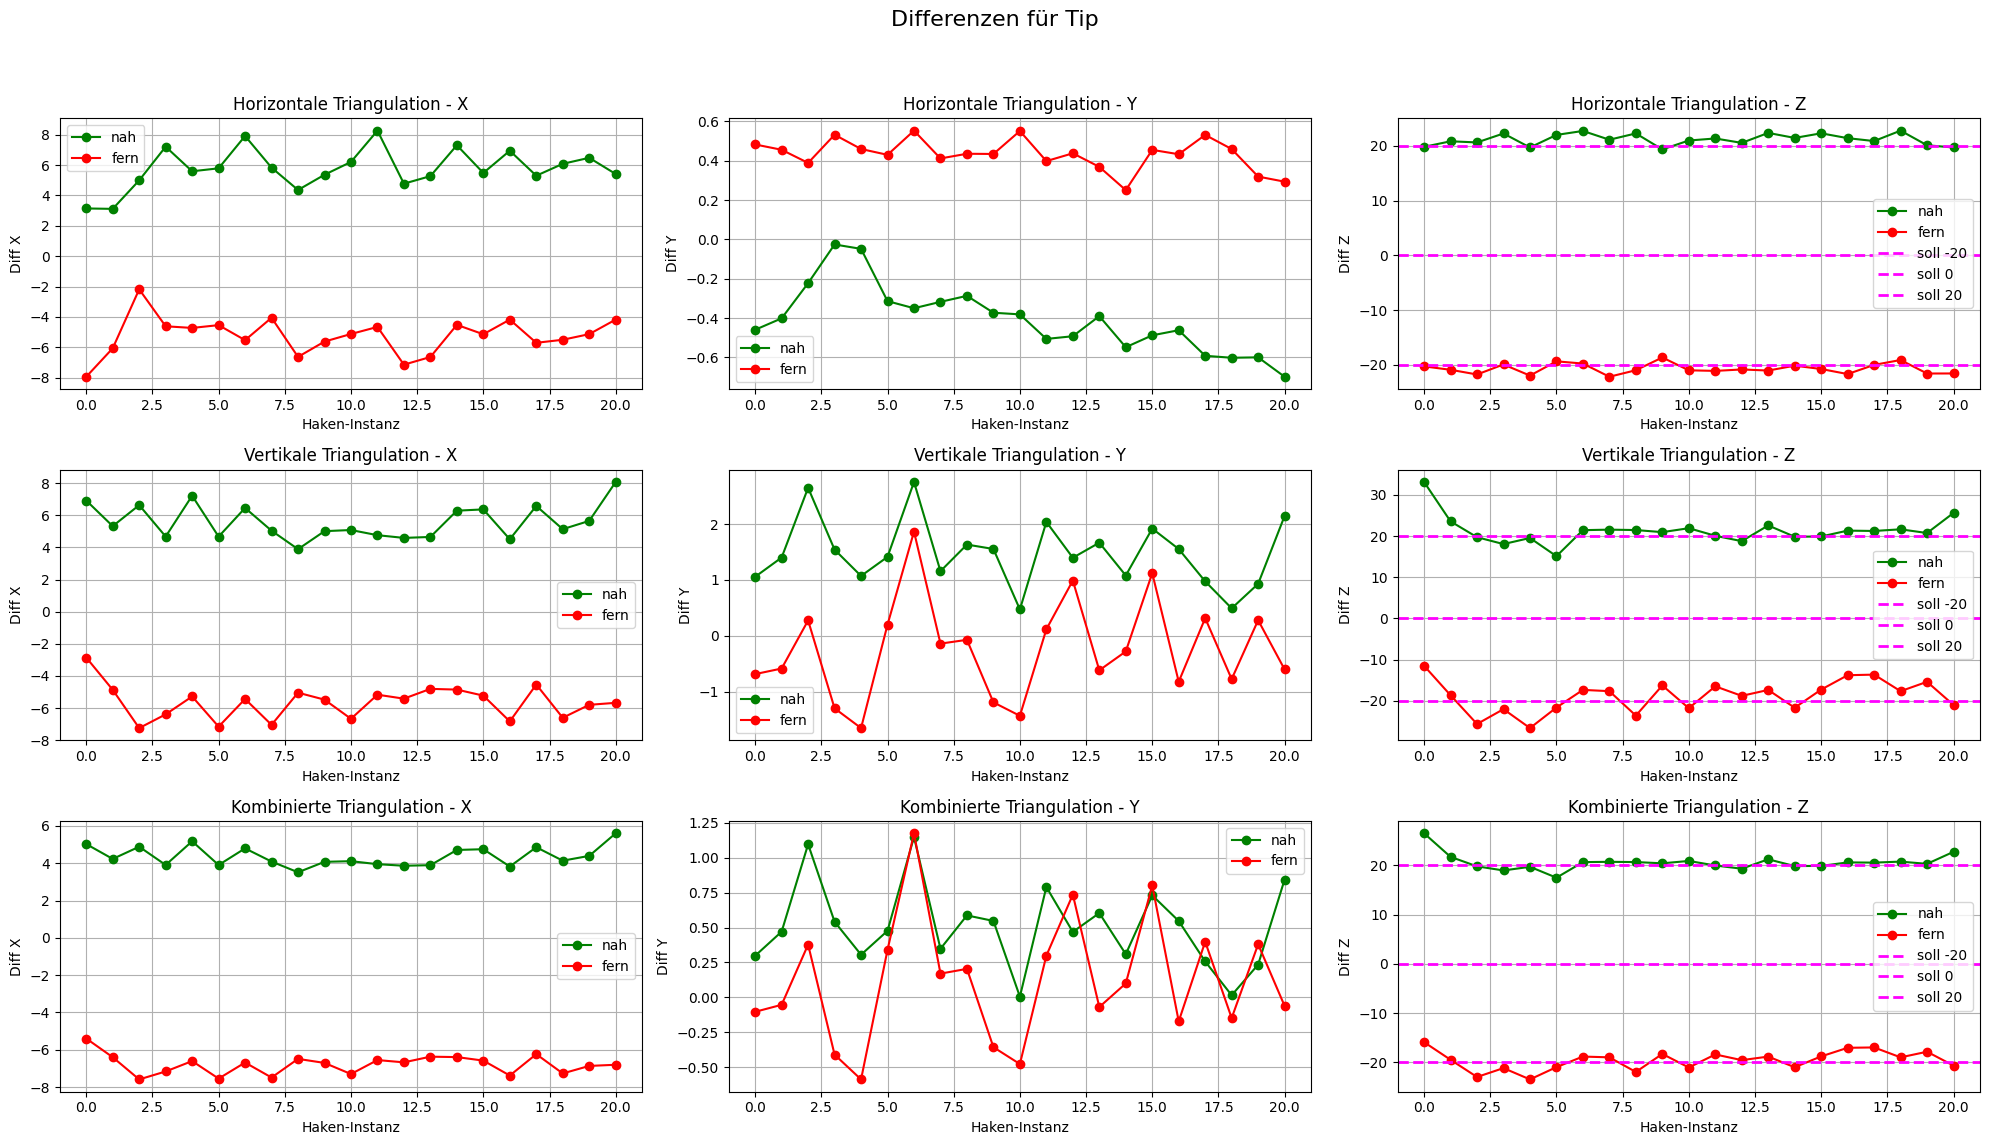

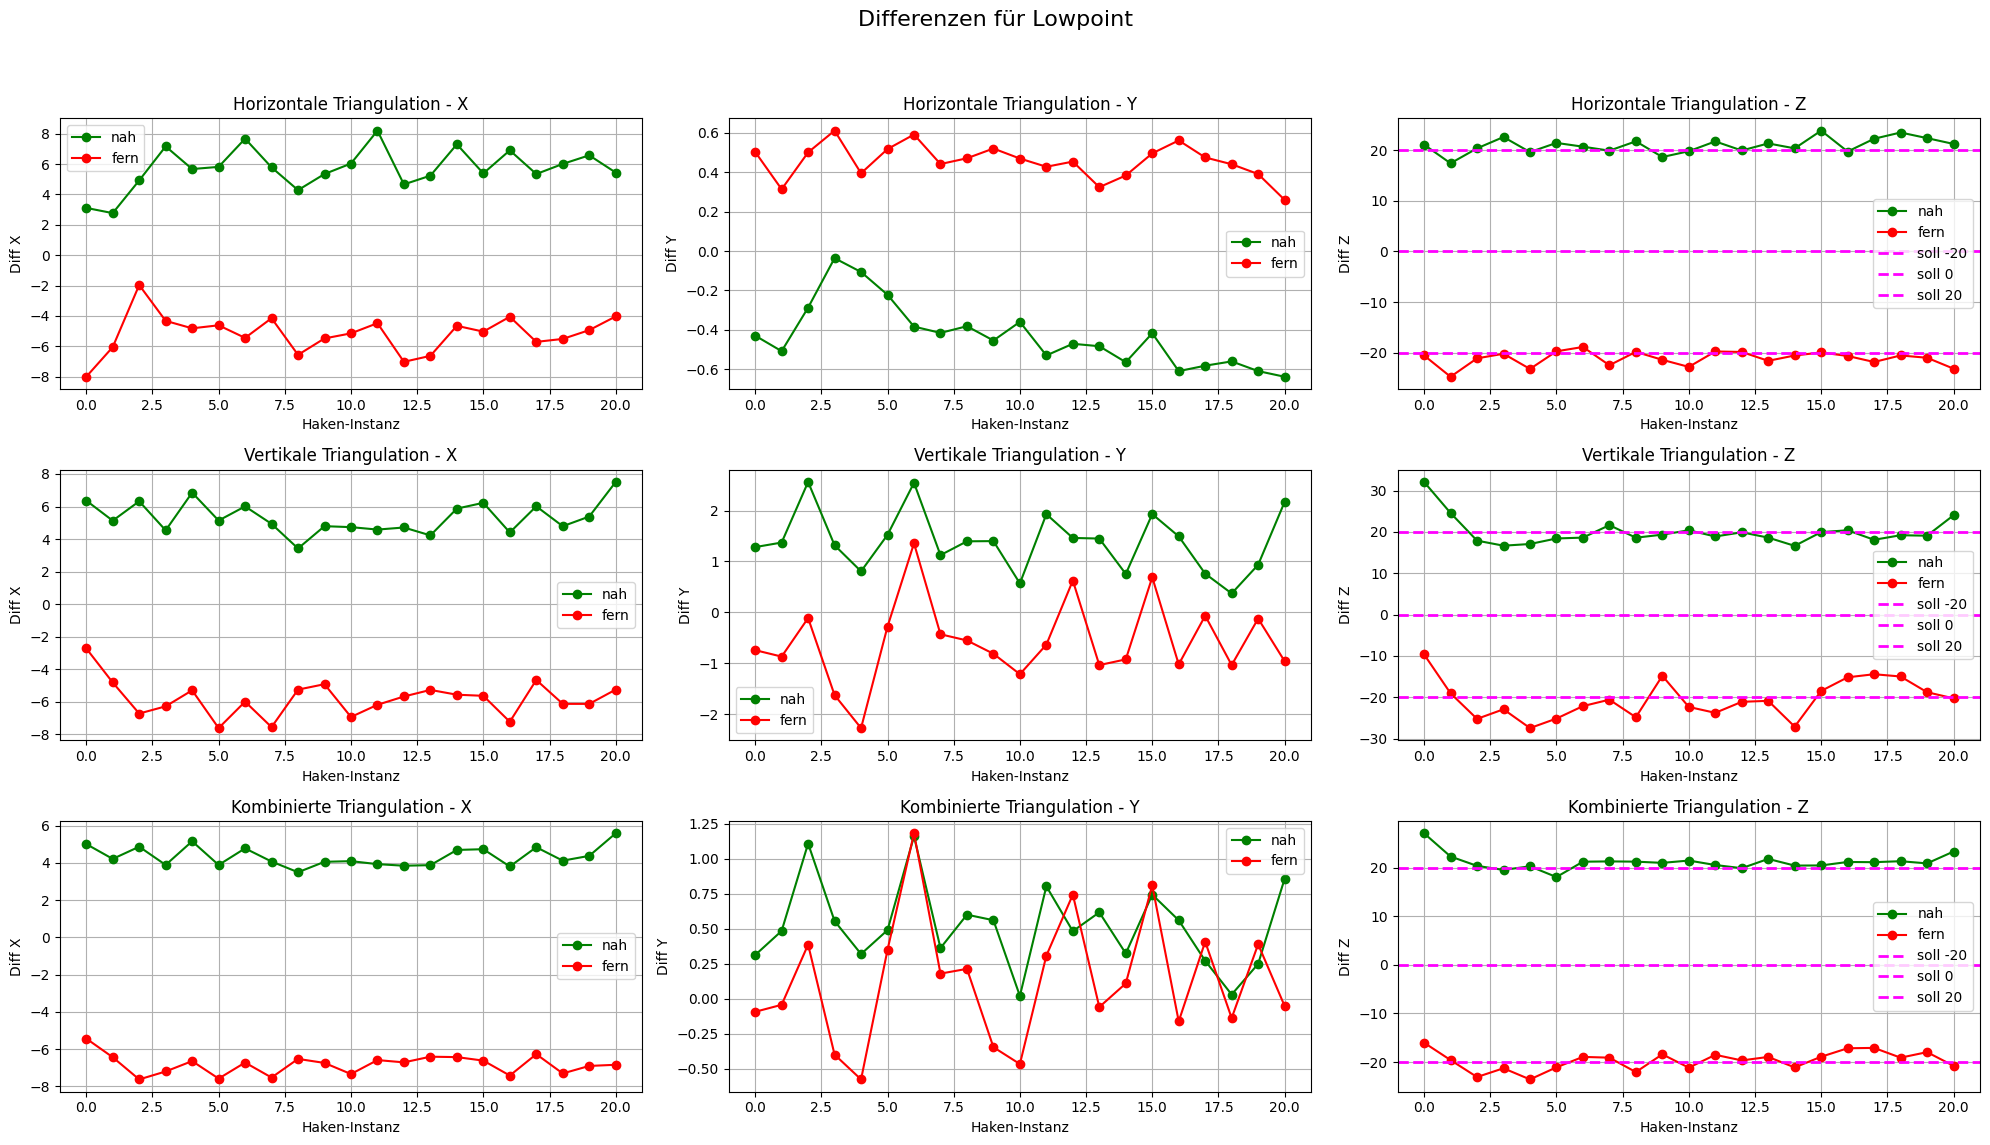

In [27]:
plot_diffs(
    horizontal_far_diffs, horizontal_near_diffs,
    vertical_far_diffs, vertical_near_diffs,
    combined_far_diffs, combined_near_diffs,
    'tip'
)

plot_diffs(
    horizontal_far_diffs, horizontal_near_diffs,
    vertical_far_diffs, vertical_near_diffs,
    combined_far_diffs, combined_near_diffs,
    'lowpoint'
)